# Cross-shore spectra
Compare spectra from 3-ADCP array (C1, C3, C6) across the Asilomar 2022 small-scale array rock.

In [1]:
# Imports
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import scipy.stats as stats
from scipy import signal
from scipy.io import loadmat
from tqdm.notebook import tqdm
import cmocean
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as mdates
from cmcrameri import cm
from PyPDF2 import PdfFileMerger, PdfFileReader
# Interactive plots
%matplotlib widget 

from roxsi_pyfuns import coordinate_transforms as rpct
from roxsi_pyfuns import transfer_functions as rptf
from roxsi_pyfuns import wave_spectra as rpws
from roxsi_pyfuns.preprocess import signature_preprocess as rpsp

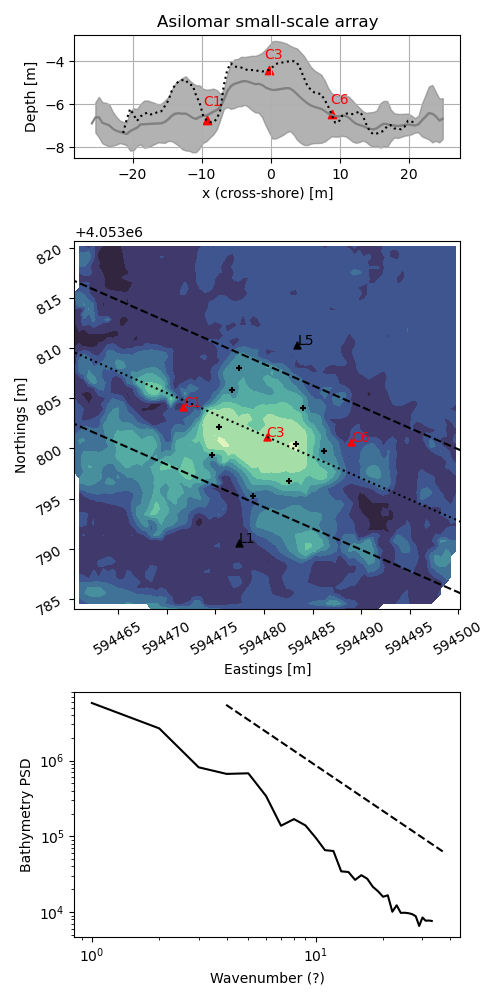

xs,xe=594439.2362573274,594531.2867426727 - ys,ye+4053825.7049564244,4053786.6318435753


In [2]:
# Paths
rootdir = r'/media/mikapm/T7 Shield/ROXSI/Asilomar2022/SmallScaleArray/'
data_root = os.path.join(rootdir, 'Signatures', 'Level1')
bathydir = os.path.join(rootdir, 'Bathy')
figdir = os.path.join(data_root, 'img')

# Read API key from environment variable
api_key = os.environ["OPENAI_API_KEY"]

# Read large-scale array mooring locations table
fn_lsa = os.path.join(rootdir, 'ROXSI2022_LSA_mooring_locations.csv')
df_lsa = pd.read_csv(fn_lsa).set_index('Mooring')

# Sig100 serial number to visualize
sers = ['103088', '103094', '103110',]
mids = ['C1', 'C3', 'C6'] # Mooring IDs

fn_bathy = os.path.join(bathydir, 'Asilomar_2022_SSA_bathy.nc')
dsb = xr.decode_cf(xr.open_dataset(fn_bathy, decode_coords='all'))

# Initialize figure and plot
plt.close()
fig, axes = plt.subplots(figsize=(5,10), nrows=3, gridspec_kw={'height_ratios': [1, 3, 2]},
                         constrained_layout=True)
axes[1].contourf(dsb.eastings, dsb.northings, dsb.z_utm, vmin=-8.0, vmax=-3.5,
            cmap=cmocean.cm.deep_r)
# Mooring locations
s = 25 # markersize
axes[1].scatter(dsb.C1_utm[0].item(), dsb.C1_utm[1].item(), marker='^', color='r', s=s)
axes[1].text(dsb.C1_utm[0].item(), dsb.C1_utm[1].item(), 'C1', color='r')
axes[1].scatter(dsb.C2_utm[0].item(), dsb.C2_utm[1].item(), marker='+', color='k', s=s)
axes[1].scatter(dsb.C3_utm[0].item(), dsb.C3_utm[1].item(), marker='^', color='r', s=s)
axes[1].text(dsb.C3_utm[0].item(), dsb.C3_utm[1].item(), 'C3', color='r')
axes[1].scatter(dsb.C4_utm[0].item(), dsb.C4_utm[1].item(), marker='+', color='k', s=s)
axes[1].scatter(dsb.C5_utm[0].item(), dsb.C5_utm[1].item(), marker='+', color='k', s=s)
axes[1].scatter(dsb.C6_utm[0].item(), dsb.C6_utm[1].item(), marker='^', color='r', s=s)
axes[1].text(dsb.C6_utm[0].item(), dsb.C6_utm[1].item(), 'C6', color='r')
axes[1].scatter(dsb.L1_utm[0].item(), dsb.L1_utm[1].item(), marker='^', color='k', s=s)
axes[1].text(dsb.L1_utm[0].item(), dsb.L1_utm[1].item(), 'L1', color='k')
axes[1].scatter(dsb.L2_utm[0].item(), dsb.L2_utm[1].item(), marker='+', color='k', s=s)
axes[1].scatter(dsb.L4_utm[0].item(), dsb.L4_utm[1].item(), marker='+', color='k', s=s)
axes[1].scatter(dsb.L5_utm[0].item(), dsb.L5_utm[1].item(), marker='^', color='k', s=s)
axes[1].text(dsb.L5_utm[0].item(), dsb.L5_utm[1].item(), 'L5', color='k')
axes[1].scatter(dsb.C2L2_utm[0].item(), dsb.C2L2_utm[1].item(), marker='+', color='k', s=s)
axes[1].scatter(dsb.C2L4_utm[0].item(), dsb.C2L4_utm[1].item(), marker='+', color='k', s=s)
axes[1].scatter(dsb.C4L2_utm[0].item(), dsb.C4L2_utm[1].item(), marker='+', color='k', s=s)
axes[1].scatter(dsb.C4L4_utm[0].item(), dsb.C4L4_utm[1].item(), marker='+', color='k', s=s)
# Axis params
axes[1].set_xlim([dsb.eastings.min(), dsb.eastings.max()])
axes[1].set_ylim([dsb.northings.min(), dsb.northings.max()])
axes[1].set_xlabel('Eastings [m]')
axes[1].set_ylabel('Northings [m]')
axes[1].tick_params(labelrotation=30)

# Mark cross-shore transect
rot_ang = 293
ang_math = 270 - rot_ang
x = dsb.eastings.values
y = dsb.northings.values
L = 50 # Length
# Make average transect of a +/- 5m wide region at 0.5 m increments
transects = {} # Dict for each individual transect
transects_n = {} # Normalized transects with distance axis
# Define origin of middle transect (crossing C3 mooring location)
x0 = dsb.C3_utm[0].item()
y0 = dsb.C3_utm[1].item()
for dxy in np.linspace(-5, 5, 21):
    x0i = x0 + dxy # x-origin of current transect
    y0i = y0 + dxy # y-origin of current transect
    x_end = x0i + L * np.cos(np.deg2rad(ang_math)) # Far-field end point
    y_end = y0i + L * np.sin(np.deg2rad(ang_math))
    x_start = x0i - L * np.cos(np.deg2rad(ang_math)) # Near-field start point
    y_start = y0i - L * np.sin(np.deg2rad(ang_math))
    xt = xr.DataArray(np.linspace(x_start, x_end, 200), dims='h') # Full line x points
    yt = xr.DataArray(np.linspace(y_start, y_end, 200), dims='h') # Full line y points
    # Take transect along xt, yt
    transect = dsb.z_utm.interp(eastings=xt, northings=yt, method='linear')
    transects['{}-{}'.format(dxy, dxy)] = transect
    # Make rotated spatial axes for transect
    x_dist = transect.eastings.values - x0i
    y_dist = transect.northings.values - y0i
    dist_axis = np.sqrt(x_dist**2 + y_dist**2)
    dist_axis[np.where(np.logical_or(x_dist<0, y_dist>0))] *= -1
    # Make dataframe with distance axis as index
    transect_norm = pd.Series(transect.values, index=dist_axis)
    transects_n['{}-{}'.format(dxy, dxy)] = transect_norm

# Plot middle cross-shore transect line on countour plot
transect = transects['{}-{}'.format(0.0, 0.0)]
axes[1].plot(transect.eastings, transect.northings, color='k', linestyle=':')
# Also plot edge transects
transect = transects['{}-{}'.format(-5.0, -5.0)]
axes[1].plot(transect.eastings, transect.northings, color='k', linestyle='--')
transect = transects['{}-{}'.format(5.0, 5.0)]
axes[1].plot(transect.eastings, transect.northings, color='k', linestyle='--')

# Plot +/- 1 std of transects around mean transect
df0 = transects_n['{}-{}'.format(0.0, 0.0)]
dft = pd.concat(transects_n, axis=1) # Merged transects with common distance index
std = dft.std(axis=1).values
meant = dft.mean(axis=1)
axes[0].fill_between(meant.index, meant, meant + 2*std, color='gray', alpha=0.6)
axes[0].fill_between(meant.index, meant, meant - 2*std, color='gray', alpha=0.6)
# Plot transect on top row
meant.plot(ax=axes[0], color='gray', linestyle='-') # Mean transect
df0.plot(ax=axes[0], color='k', linestyle=':') # Middle transect
# Mark mooring locations
xc1 = dsb.C1_utm[0].item() - x0
yc1 = dsb.C1_utm[1].item() - y0
dc1 = np.sqrt(xc1**2 + yc1**2) * (-1) # -1 to get marker to the left of origin
dc1_i = np.argmin(np.abs(df0.index.values - dc1))
axes[0].scatter(df0.index[dc1_i], df0.iloc[dc1_i], marker='^', color='r')
axes[0].text(df0.index[dc1_i]-0.5, df0.iloc[dc1_i]+0.65, 'C1', color='r')
xc3 = dsb.C3_utm[0].item() - x0
yc3 = dsb.C3_utm[1].item() - y0
dc3 = np.sqrt(xc3**2 + yc3**2)
dc3_i = np.argmin(np.abs(df0.index.values - dc3))
axes[0].scatter(df0.index[dc3_i], df0.iloc[dc3_i], marker='^', color='r')
axes[0].text(df0.index[dc3_i]-0.75, df0.iloc[dc3_i]+0.5, 'C3', color='r')
xc6 = dsb.C6_utm[0].item() - x0
yc6 = dsb.C6_utm[1].item() - y0
dc6 = np.sqrt(xc6**2 + yc6**2)
dc6_i = np.argmin(np.abs(df0.index.values - dc6))
axes[0].scatter(df0.index[dc6_i], df0.iloc[dc6_i], marker='^', color='r')
axes[0].text(df0.index[dc6_i]-0.15, df0.iloc[dc6_i]+0.5, 'C6', color='r')
axes[0].set_title('Asilomar small-scale array')
axes[0].set_xlabel('x (cross-shore) [m]')
axes[0].set_ylabel('Depth [m]')
axes[0].grid()

# Compute spectrum of bathymetry and plot it on the bottom row
# Array must be square, so crop edges from bathy array in x direction
# Follow example at 
# https://bertvandenbroucke.netlify.app/2019/05/24/computing-a-power-spectrum-in-python/
bathy_square = dsb.isel(eastings=slice(7,-7), northings=slice(2,-2)).copy()
npix = bathy_square.z_utm.shape[0]
# Take FFT of bathy
image = bathy_square.z_utm.values
fourier_image = np.fft.fftn(image)
# Get variance
fourier_amplitudes = np.abs(fourier_image)**2
# Construct wavenumber array
dx = dsb.eastings.values[1] - dsb.eastings.values[0]
kfreq = np.fft.fftfreq(npix) * npix
# Create 2D wavenumber grid
kfreq2D = np.meshgrid(kfreq, kfreq)
# We are not really interested in the actual wave vectors, but rather in their norm
knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)
# Flatten arrays
knrm = knrm.flatten()
fourier_amplitudes = fourier_amplitudes.flatten()
# Bin amplitudes in wavenumber space
kbins = np.arange(0.5, npix//2+1, 1.)
# Note that the maximum wave number will equal half the pixel size of the image. 
# This is because half of the Fourier frequencies can be mapped back to negative 
# wavenumbers that have the same norm as their positive counterpart.
kvals = 0.5 * (kbins[1:] + kbins[:-1])
# Compute the average Fourier amplitude (squared) in each bin
Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                     statistic = "mean",
                                     bins = kbins)
# To get the total power, we need to multiply with the volume in each bin
Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)

# Plot bathymetry power spectrum on bottom row
axes[2].loglog(kvals, Abins, color='k')
# Plot k^-2 line
ksmin, ksmax = axes[2].get_xlim()
ks = np.linspace(ksmin, ksmax)
axes[2].loglog(ks[4:-3], 15*Abins.max() * ks[4:-3]**(-2), color='k', linestyle='--')
axes[2].set_xlabel('Wavenumber (?)')
axes[2].set_ylabel('Bathymetry PSD')

plt.tight_layout()
plt.show()


print('xs,xe={},{} - ys,ye+{},{}'.format(x_start, x_end, y_start, y_end))

## Concatenate daily spectra
Also plot time series of wave conditions during the experiment.

Reading 103088-C1 netcdf files ...


  0%|          | 0/27 [00:00<?, ?it/s]

Reading 103094-C3 netcdf files ...


  0%|          | 0/26 [00:00<?, ?it/s]

Reading 103110-C6 netcdf files ...


  0%|          | 0/28 [00:00<?, ?it/s]

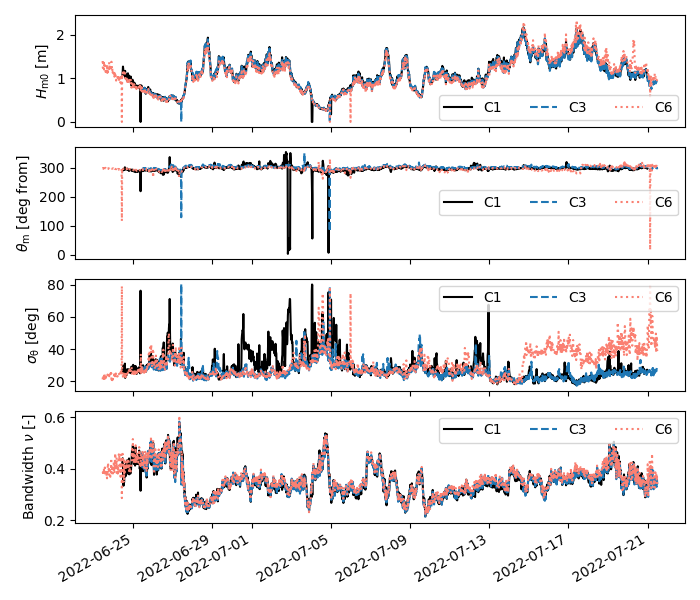

In [80]:
# Sig100 serial number to visualize
sers = ['103088', '103094', '103110',]
mids = ['C1', 'C3', 'C6'] # Mooring IDs
# Use all available serial numbers
spec_key = 'ASTd' # Spectrum heave product
# Save mean datasets in dict
dsds = {} # Spectrum datasets
for ser, mid in zip(sers, mids):
    print('Reading {}-{} netcdf files ...'.format(ser, mid))
    # Get current serial number's spectrum directories
    specdir = os.path.join(data_root, '{}'.format(ser), 'Spectra') # Spectra netcdf directory
    # List spectrum netcdf files for specified serial number
    fns_nc_spec = sorted(glob.glob(os.path.join(specdir, '*{}_*.nc'.format(spec_key))))
    dssl = [] # Empty list for concatenating spectrum datasets
    # Iterate over and read files, and append to list for concatenating
    for fns in tqdm(fns_nc_spec):
        # Read spectrum netcdf
        dss = xr.decode_cf(xr.open_dataset(fns, decode_coords='all'))
        dssl.append(dss) # Append daily spectra to list

    # Concatenate datasets into one
    dss = xr.concat(dssl, dim='time')
    dsds[mid] = dss # Save in dict

# Plot time series
fig, axes = plt.subplots(figsize=(7,6), nrows=4, sharex=True, constrained_layout=True)
lss = ['-', '--', ':'] # Linestyles
cls = ['k', 'C0', 'salmon']
for i, (mid, ser) in enumerate(zip(mids, sers)):
    # Hs on top
    dsds[mid].Hm0.plot(ax=axes[0], color=cls[i], linestyle=lss[i], label=mid)
    axes[0].set_ylabel(r'$H_\mathrm{m0}$ [m]')
    # Mean/peak dir on 2nd row
    dsds[mid].mdir.plot(ax=axes[1], color=cls[i], linestyle=lss[i], label=mid)
    axes[1].set_ylabel(r'$\theta_\mathrm{m}$ [deg from]')
    # Directional spread on 3rd row
    dsds[mid].dspr.plot(ax=axes[2], color=cls[i], linestyle=lss[i], label=mid)
    axes[2].set_ylabel(r'$\sigma_\mathrm{\theta}$ [deg]')
    # Frequency bandwidth on 4th row
    dsds[mid].nu_LH57.plot(ax=axes[3], color=cls[i], linestyle=lss[i], label=mid)
    axes[3].set_ylabel(r'Bandwidth $\nu$ [-]')

for ax in axes:
    ax.set_xlabel(None)
    ax.legend(ncol=3)

plt.tight_layout()
plt.show()


## Directional moments


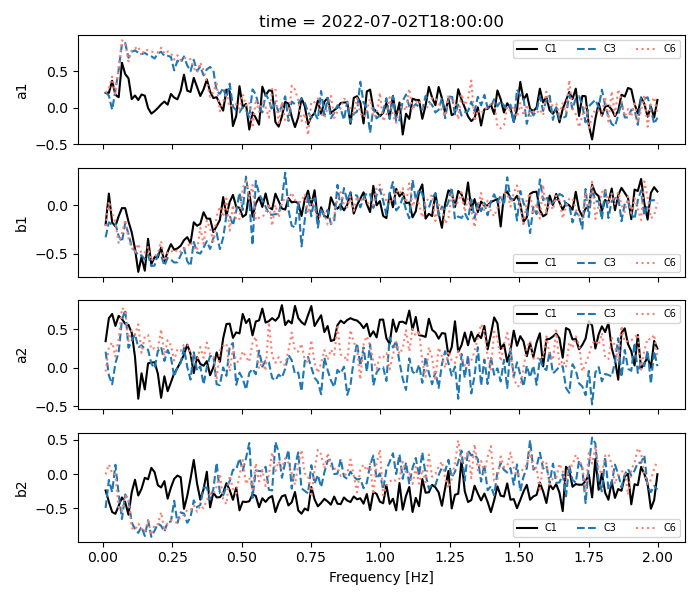

In [5]:
# Plot comparison of a1, b1, a2, b2 moments for 2022-07-02-19:00
fig, axes = plt.subplots(figsize=(7,6), nrows=4, sharex=True)
t0 = pd.Timestamp('2022-07-02 18:00:00')
lss = ['-', '--', ':'] # Linestyles
cls = ['k', 'C0', 'salmon']
for i,mid in enumerate(mids):
    # Plot a1 on first row etc
    dsds[mid].sel(time=t0).a1.plot(ax=axes[0], label=mid, color=cls[i], linestyle=lss[i])
    axes[0].set_ylabel('a1')
    axes[0].set_xlabel(None)
    dsds[mid].sel(time=t0).b1.plot(ax=axes[1], label=mid, color=cls[i], linestyle=lss[i])
    axes[1].set_ylabel('b1')
    axes[1].set_xlabel(None)
    axes[1].set_title(None)
    dsds[mid].sel(time=t0).a2.plot(ax=axes[2], label=mid, color=cls[i], linestyle=lss[i])
    axes[2].set_ylabel('a2')
    axes[2].set_xlabel(None)
    axes[2].set_title(None)
    dsds[mid].sel(time=t0).b2.plot(ax=axes[3], label=mid, color=cls[i], linestyle=lss[i])
    axes[3].set_ylabel('b2')
    axes[3].set_title(None)
axes[-1].set_xlabel('Frequency [Hz]')

for ax in axes:
    ax.legend(ncol=3, fontsize=7)

plt.tight_layout()
plt.show()



## Directional spectra

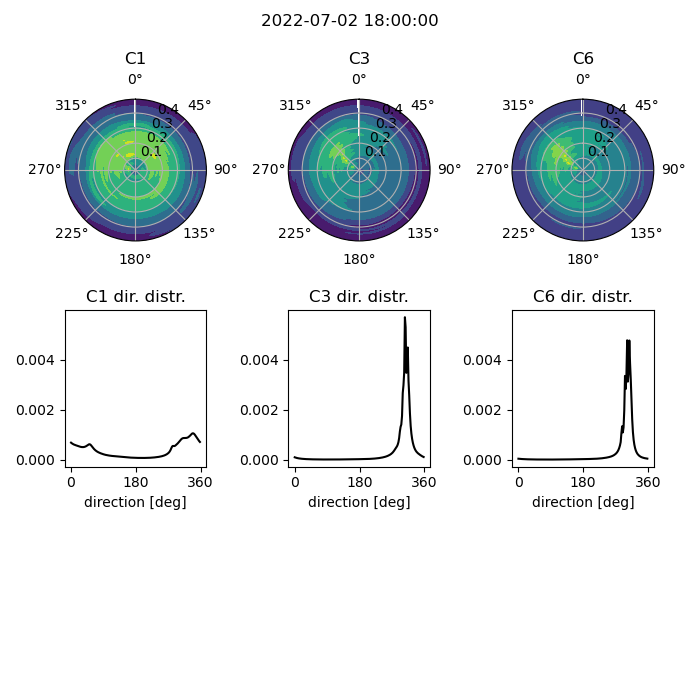

In [6]:
# Plot directional spectra vs directional distr. for given time
fig = plt.figure(figsize=(7,7),)
fig.subplots_adjust(hspace=0, wspace=0)
ap = [] # Polar axes
ap.append(fig.add_subplot(331, projection='polar'))
ap.append(fig.add_subplot(332, projection='polar'))
ap.append(fig.add_subplot(333, projection='polar'))
an = [] # Normal axes
an.append(plt.subplot(334))
an.append(plt.subplot(335, sharey=an[0]))
an.append(plt.subplot(336, sharey=an[0]))
t0 = pd.Timestamp('2022-07-02 18:00:00')
lss = ['-', '--', ':'] # Linestyles
cls = ['k', 'C0', 'salmon']
for i, mid in enumerate(mids):
    # Plot directional spectrum in polar coordinates
    cs1 = ap[i].contourf(np.deg2rad(dsds[mid].Efth.direction.values),
        dsds[mid].Efth.sel(time=t0, freq=slice(0.01, 0.5)).freq.values,
        dsds[mid].Efth.sel(time=t0, freq=slice(0.01, 0.5)).values,
        norm=colors.LogNorm(),)
    # Fix directions
    ap[i].set_theta_zero_location("N")
    ap[i].set_theta_direction(-1)
    ap[i].set_title('{}'.format(mid))
    # Plot directional distribution below
    eth = dsds[mid].Efth.sel(time=t0).integrate(coord='freq')
    an[i].plot(dsds[mid].direction.values, eth, color='k')
    an[i].set_title('{} dir. distr.'.format(mid))
    an[i].set_xlabel('direction [deg]')
    an[i].set_xticks([0, 180, 360])

# plt.subplots_adjust(wspace=0., hspace=0.)
plt.suptitle(t0)
plt.tight_layout()
plt.show()

## Spectral harmonics

0it [00:00, ?it/s]

0it [00:00, ?it/s]

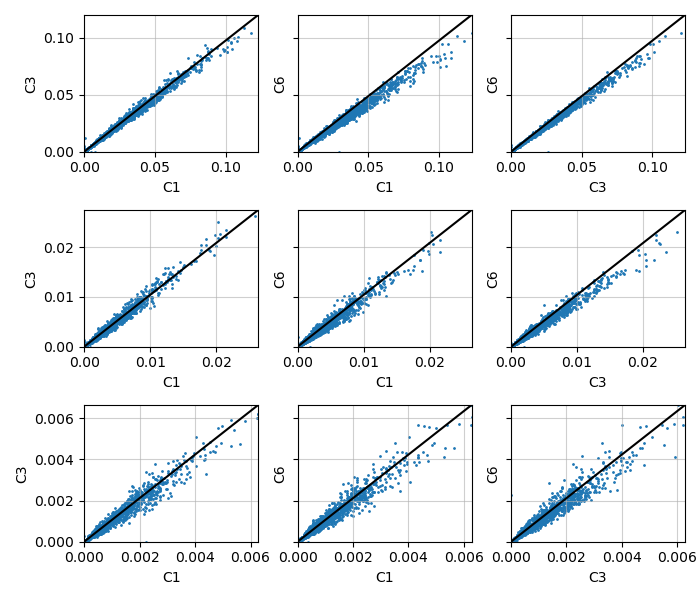

In [99]:
from functools import reduce
# Compute spectral energy at fp and its higher harmonics
m0_fp = {'C1':[], 'C3':[], 'C6':[]}
m0_2fp = {'C1':[], 'C3':[], 'C6':[]}
m0_3fp = {'C1':[], 'C3':[], 'C6':[]}

# First get consistent fp estimates by averaging over all 3 moorings
dfc = {} # Dict to store dataframes with timestamps and peak freqs
for i,mid in tqdm(enumerate(mids)):
    # Pick current dataset
    ds = dsds[mid].copy()
    # Remove duplicates
    ds = ds.sel(time=~ds.get_index("time").duplicated())
    # Generate dataframe with timestamps and fp
    dfc[mid] = pd.DataFrame(data={'fp_{}'.format(mid): (1 / ds.Tp_ind.values),
                                  'time': ds.time.values}, 
                            )
# Get union of timestamps in all 3 dataframes
lst = [dfc['C1'], dfc['C3'], dfc['C6']]
dfm = reduce(lambda l,r: l.merge(r, on='time'), lst)
# Set time as index and take median fp for each timestamp
dfm = dfm.set_index('time').median(axis=1)
dfm.index = pd.to_datetime(dfm.index)
t0 = dfm.index[0]
t1 = dfm.index[-1]
t1 = pd.Timestamp('2022-07-14 11:00:00')

# Iterate over Mooring IDs and integrate spectra
for i,mid in tqdm(enumerate(mids)):
    ds = dsds[mid].copy()
    ds = ds.sel(time=~ds.get_index("time").duplicated())
    # Iterate over timestamps
    for ts in ds.time.values:
        spec = ds.sel(time=ts) # Select current spectrum
        # fp = 1 / spec.Tp_ind.item() # Peak frequency from Tp index
        if ts >= t0 and ts <= t1 and ts in dfm.index:
            fp = dfm.loc[pd.Timestamp(ts)].item()
            df = (spec.freq[1] - spec.freq[0]).item() # Frequency resolution
            # Integrate spectrum around peak frequency and save to dict
            m0_fp[mid].append(spec.Ezz.sel(freq=slice(fp-df*2, fp+df*2)).integrate(
                coord='freq').item())
            # Integrate spectrum around 2x peak frequency and save to dict
            m0_2fp[mid].append(spec.Ezz.sel(freq=slice(2*fp-df*2, 2*fp+df*2)).integrate(
                coord='freq').item())
            # Integrate spectrum around 3x peak frequency and save to dict
            m0_3fp[mid].append(spec.Ezz.sel(freq=slice(3*fp-df*2, 3*fp+df*2)).integrate(
                coord='freq').item())

# Plot
fig, axes = plt.subplots(figsize=(7,6), ncols=3, nrows=3, sharex='row', sharey='row')
# Peak freq energy on first row
axes[0,0].scatter(m0_fp['C1'], m0_fp['C3'], s=1)
axes[0,0].set_xlabel('C1')
axes[0,0].set_ylabel('C3')
axes[0,1].scatter(m0_fp['C1'], m0_fp['C6'], s=1)
axes[0,1].set_xlabel('C1')
axes[0,1].set_ylabel('C6')
axes[0,2].scatter(m0_fp['C3'], m0_fp['C6'], s=1)
axes[0,2].set_xlabel('C3')
axes[0,2].set_ylabel('C6')
# First harmonics on middle row
ratio_12_11 = np.array(m0_2fp['C1']) / np.array(m0_fp['C1'])
ratio_12_33 = np.array(m0_2fp['C3']) / np.array(m0_fp['C3'])
axes[1,0].scatter(m0_2fp['C1'], m0_2fp['C3'], s=1)
# axes[1,0].scatter(ratio_12_11, ratio_12_33, s=1)
axes[1,0].set_xlabel('C1')
axes[1,0].set_ylabel('C3')
ratio_12_66 = np.array(m0_2fp['C6']) / np.array(m0_fp['C6'])
# axes[1,1].scatter(ratio_12_11, ratio_12_66, s=1)
axes[1,1].scatter(m0_2fp['C1'], m0_2fp['C6'], s=1)
axes[1,1].set_xlabel('C1')
axes[1,1].set_ylabel('C6')
axes[1,2].scatter(m0_2fp['C3'], m0_2fp['C6'], s=1)
# axes[1,2].scatter(ratio_12_33, ratio_12_66, s=1)
axes[1,2].set_xlabel('C3')
axes[1,2].set_ylabel('C6')
# Second harmonics on last row
axes[2,0].scatter(m0_3fp['C1'], m0_3fp['C3'], s=1)
axes[2,0].set_xlabel('C1')
axes[2,0].set_ylabel('C3')
axes[2,1].scatter(m0_3fp['C1'], m0_3fp['C6'], s=1)
axes[2,1].set_xlabel('C1')
axes[2,1].set_ylabel('C6')
axes[2,2].scatter(m0_3fp['C3'], m0_3fp['C6'], s=1)
axes[2,2].set_xlabel('C3')
axes[2,2].set_ylabel('C6')

for ax in axes.flat:
    ax.grid(alpha=0.6)
    # Remove empty space from x,y axes
    ax.autoscale(enable=True, tight=True)
    # One-to-one lines
    ax.plot(ax.get_xlim(), ax.get_ylim(), color='k')

plt.tight_layout()
plt.show()


## Spectograms
Make daily spectograms for C1 vs. C3 vs. C6 for the entire experiment. Save to file, don't show here.

In [319]:
import matplotlib.colors as colors
import matplotlib.dates as mdates

# Read 4-m wind speed data
fn_wind = os.path.join(rootdir, 'ROXSI_4mwind.csv')
dfw = pd.read_csv(fn_wind, parse_dates=['time']).set_index('time')
# dfw.index = dfw.index.floor('1H').to_pydatetime()

mids = ['C1', 'C3', 'C6'] # Mooring IDs

# First get consistent fp estimates by averaging over all 3 moorings
dfc = {} # Dict to store dataframes with timestamps and peak freqs
for i,mid in tqdm(enumerate(mids)):
    # Pick current dataset
    ds = dsds[mid].copy()
    # Remove duplicates
    ds = ds.sel(time=~ds.get_index("time").duplicated())
    # Generate dataframe with timestamps and fp
    dfc[mid] = pd.DataFrame(data={'fp_{}'.format(mid): (1 / ds.Tp_ind.values),
                                  'time': ds.time.values}, 
                            )
# Get union of timestamps in all 3 dataframes
lst = [dfc['C1'], dfc['C3'], dfc['C6']]
dfm = reduce(lambda l,r: l.merge(r, on='time'), lst)
# Set time as index and take median fp for each timestamp
dfm = dfm.set_index('time').median(axis=1)
dfm.index = pd.to_datetime(dfm.index)
t0 = dfm.index[0]
t1 = dfm.index[-1]
# t1 = pd.Timestamp('2022-07-14 11:00:00')
# Min/max frequencies to plot
fmin = 0
fmax = 0.5

# Make daily time index
times_daily = pd.date_range(t0.date(), t1.date(), freq='1D')

# Iterate over days
for date in times_daily:
    # Check if figure already saved
    fn_img = os.path.join(figdir, 
        'spectogram_c136_{}.pdf'.format(''.join(str(date.date()).split('-'))))
    if not os.path.isfile(fn_img):
        # Initialize figure
        fig, axes = plt.subplots(figsize=(7,6), nrows=4, sharex=True, constrained_layout=True)
        # Iterate over Mooring IDs and plot spectograms
        for i, mid in enumerate(mids):
            ds = dsds[mid].copy()
            # Remove duplicates
            ds = ds.sel(time=~ds.get_index("time").duplicated())
            # Select current date and frequency range
            ds = ds.sel(time=str(date.date()), freq=slice(fmin, fmax))
            # Normalize spectrum by peak energy
            ds['Ezz_n'] = (['time', 'freq'], ds.Ezz.values)
            for ts in ds.time.values:
                if ts >= t0 and ts <= t1 and ts in dfm.index:
                    # Select current spectrum
                    spec = ds[['Ezz', 'Tp_ind']].sel(time=ts).copy() 
                    fpi = (np.abs(spec.freq.values - (1/spec.Tp_ind).item())).argmin()
                    ds.Ezz_n.sel(time=ts).values /= spec.Ezz.isel(freq=fpi).item()
            # Plot spectogram of current date
            im = ds.Ezz_n.plot.pcolormesh(x='time', y='freq', ax=axes[i], add_colorbar=False,
                                        norm=colors.LogNorm(vmin=ds.Ezz_n.min(), vmax=1),
                                        cmap=cmocean.cm.thermal)
            cax = axes[i].inset_axes([1.02, 0.0, 0.03, 1.0])
            fig.colorbar(im, ax=axes[i], cax=cax)
    #         dfm.loc[str(date.date())].plot(ax=axes[i],  linestyle='-', 
    #             color='k', alpha=0.4)
    #         (2 * dfm.loc[str(date.date())]).plot(ax=axes[i],  linestyle='--', 
    #             color='k', alpha=0.4)
    #         (3 * dfm.loc[str(date.date())]).plot(ax=axes[i],  linestyle=':', 
    #             color='k', alpha=0.4)
            alpha = 0.6 # alpha for fp and higher harmonics lines
            (1 / ds.Tp_ind).plot(ax=axes[i], linestyle='-', color='k', alpha=alpha, label=r'$f_\mathrm{p}$')
    #         (2 * (1 / ds.Tp_ind)).plot(ax=axes[i], linestyle='--', color='k', alpha=alpha, 
    #                                    label=r'$2f_\mathrm{p}$')
    #         (3 * (1 / ds.Tp_ind)).plot(ax=axes[i], linestyle=':', color='k', alpha=alpha,
    #                                    label=r'$3f_\mathrm{p}$')
        # Labels/titles/annotations
        axes[0].set_title('Spectogram for {}'.format(str(date.date())))
        axes[0].legend(ncol=3, loc='upper left', fontsize=7, bbox_to_anchor=(0.0, 1.28))
        # Wind speed on last row
        axes[3].plot(dfw.loc[str(date.date())].index.round('1H'), dfw['U4_hourly'].loc[str(date.date())],
                    color='k')
        axes[3].set_ylim([0, 10])
        axes[3].set_yticks([0, 2, 4, 6, 8, 10])
        axes[3].set_ylabel(r'$U_4$ [m/s]')
        axes[3].grid()
        # Text in the x axis will be displayed in 'YYYY-mm' format.
        axes[3].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        # Rotates and right-aligns the x labels so they don't crowd each other.
    #     for label in axes[3].get_xticklabels(which='major'):
    #         label.set(rotation=30, horizontalalignment='right')
        # On twin axis plot Hs
        axh = axes[3].twinx()
        ds.Hm0.plot(ax=axh, color='r', linestyle='--')
        axh.set_ylim([0, 2.5])
        axh.set_ylabel(r'$H_\mathrm{s}$ [m]', color='r')
        axh.set_yticks([0, 0.5, 1, 1.5, 2, 2.5])
        axh.tick_params(axis='y', colors='red')
        axh.set_xlabel(None)
        for ii, ax in enumerate(axes):
            ax.set_xlabel(None)
            if ii < 3:
                ax.annotate(mids[ii], xy=(0.03, 0.85), xycoords='axes fraction',
                            bbox=dict(facecolor='w', edgecolor='k', pad=2))
                ax.set_ylabel('Freq. [Hz]')
                ax.set_ylim([fmin, fmax])

        plt.tight_layout()
        plt.subplots_adjust(hspace=0.1,)
        plt.savefig(fn_img, bbox_inches='tight', dpi=300)
        # plt.show()
        plt.close()

# Combine all individual spectogram figures into one pdf
fn_all = os.path.join(figdir, 'all_spectograms_c136.pdf')
fns_pdf = sorted(glob.glob(os.path.join(figdir, 'spectogram*.pdf')))
if len(fns_pdf):
    # Call the PdfFileMerger
    mergedObject = PdfFileMerger()
    # Loop through all pdf files and append their pages
    for fn in fns_pdf:
        mergedObject.append(PdfFileReader(fn, 'rb'))
    # Write all the files into a file which is named as shown below
    if not os.path.isfile(fn_all):
        print('Merging HPR pdfs into one ...')
        mergedObject.write(fn_all)



0it [00:00, ?it/s]

Merging HPR pdfs into one ...


## 2-h spectra
Estimate frequency spectra for 2-hr periods and make daily spectral plots comparing C1 vs. C3 vs. C6.

In [333]:
mids = ['C1', 'C3', 'C6'] # Mooring IDs
sers = ['103088', '103094', '103110'] # Serial numbers

# Make date range array for iterating over
t0 = pd.Timestamp('2022-06-26 00:00:00') # start date
t1 = pd.Timestamp('2022-07-20 00:00:00') # end date
date_range = pd.date_range(t0, t1, freq='1D')

# Plot parameters
colors = ['indigo', 'royalblue', 'turquoise']
ann = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', 
       '(g)', '(h)', '(i)', '(j)', '(k)', '(l)',
      ]

# Iterate over dates in requested period and compute spectra
for date in date_range:
    # print(str(date.date()))
    # Figure filename
    fn_fig = os.path.join(figdir, 'daily_2h_spec_c136_{}.pdf'.format(str(date.date())))
    if not os.path.isfile(fn_fig):
        # Initialize daily spectra figure
        fig, axes = plt.subplots(figsize=(7,7), nrows=3, ncols=4, sharex=True, sharey=True,
                                constrained_layout=True)
        # Iterate over mooring IDs and serial numbers
        for i, (mid, ser) in enumerate(zip(mids, sers)):
            # Signature velocity netcdf directory
            veldir = os.path.join(data_root, '{}'.format(ser)) 
            # List netcdf files in veldir
            fns_v = sorted(glob.glob(os.path.join(veldir, 'Asilomar_*.nc')))
            # Read Signature velocity dataset for current date
            datestr = '{}{:02d}{:02d}'.format(date.year, date.month, date.day)
            fn_sig = [f for f in fns_v if datestr in f]
            sk = np.logical_and(np.logical_or(mid=='C3', mid=='C6'), str(date.date())=='2022-06-30')
            if not sk:
                ds = xr.decode_cf(xr.open_dataset(fn_sig[0], decode_coords='all'))
            else:
                fn_sig = [f for f in fns_v if '20220701' in f]
                ds = xr.decode_cf(xr.open_dataset(fn_sig[0], decode_coords='all'))
            # Iterate over 2-h periods for spectra
            time_range = pd.date_range(date, date + pd.Timedelta(days=1), freq='2H')
            for si, (t0s, t1s) in enumerate(zip(time_range[:-1], time_range[1:])):
                # Take 20-min slice from dataset
                seg = ds.sel(time=slice(t0s, t1s)).copy() # Segment slice
                # Test directional wave spectrum function
                z = seg.ASTd_eta.values
                u = seg.vEhpr.isel(range=4).values
                v = seg.vNhpr.isel(range=4).values
                depth = seg.z_lin.mean().item()
                spec = rpws.spec_uvz(z, u=u, v=v, fs=4, depth=depth)
                # Plot current spectrum
                spec.Ezz.plot(ax=axes.flat[si], color=colors[i], linewidth=0.75, label=mid)
                df = spec.freq.values[1] - spec.freq.values[0]
                fp = (1 / spec.Tp_ind).item()
                if mid == 'C1':
                    # Mark fp and harmonics
                    for hi in range(1,7):
                        axes.flat[si].axvspan((hi*fp-df), (hi*fp+df), color='gray', alpha=0.5)
                # Annotate date and subplot letter
                if si == 0:
                    axes.flat[si].annotate('{}-{}'.format(t0s.strftime('%H:%M'), t1s.strftime('%H:%M')), 
                                        xy=(0.05,0.33), xycoords='axes fraction', fontsize=8)
                else:
                    axes.flat[si].annotate('{}-{}'.format(t0s.strftime('%H:%M'), t1s.strftime('%H:%M')), 
                                        xy=(0.05,0.05), xycoords='axes fraction', fontsize=8)
                axes.flat[si].annotate(ann[si], xy=(0.05,0.9), xycoords='axes fraction',
                                    fontsize=12)
        axes[0,0].legend(loc='lower left', fontsize=8)
        for ax in axes.flat:
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_xlabel(None)
            ax.set_ylabel(None)
        for ax in axes[-1, :]:
            ax.set_xlabel('Freq. [Hz]')
        plt.suptitle('C1 vs. C3 vs. C6 AST spectra {}'.format(str(date.date())))
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.1, wspace=0.1)
        plt.savefig(fn_fig, bbox_inches='tight', dpi=300)
        # plt.show()
        plt.close()

# Combine all individual spectrum figures into one pdf
fn_all = os.path.join(figdir, 'all_daily_2h_spec_c136.pdf')
fns_pdf = sorted(glob.glob(os.path.join(figdir, 'daily_2h*.pdf')))
if len(fns_pdf):
    # Call the PdfFileMerger
    mergedObject = PdfFileMerger()
    # Loop through all pdf files and append their pages
    for fn in fns_pdf:
        mergedObject.append(PdfFileReader(fn, 'rb'))
    # Write all the files into a file which is named as shown below
    if not os.path.isfile(fn_all):
        print('Merging HPR pdfs into one ...')
        mergedObject.write(fn_all)

Merging HPR pdfs into one ...


## Energy fluxes
Incoming energy flux $E_\mathrm{in}$ ratios of C3 vs. C1, C6 vs. C3 and C6 vs. C1.

  0%|          | 0/26 [00:00<?, ?it/s]

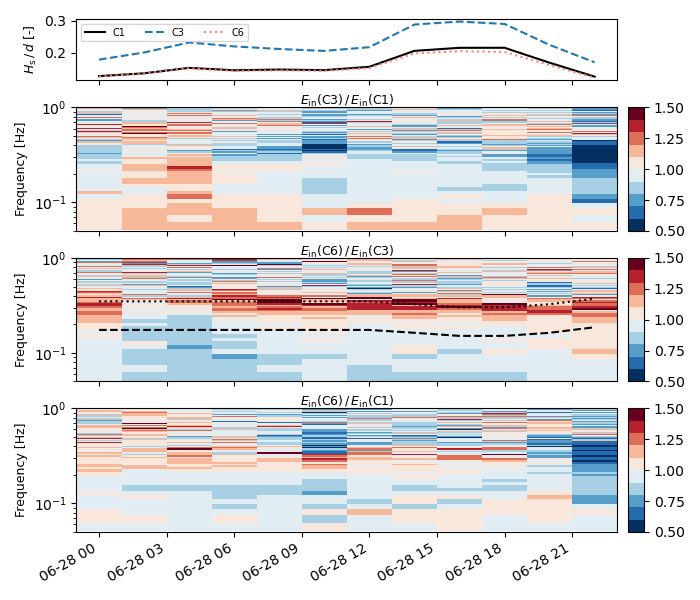

ValueError: 

In [17]:
import matplotlib.colors as colors
import matplotlib.dates as mdates
from cmcrameri import cm

def DoRotation(u, v, rot=0):
    """
    Rotate velocity components u and v by angle rot [rad].
    """
    # Clockwise, 2D rotation matrix
    RotMatrix = np.array([[np.cos(rot),  np.sin(rot)],
                          [-np.sin(rot), np.cos(rot)]])
    return RotMatrix @ np.vstack([u, v])

mids = ['C1', 'C3', 'C6'] # Mooring IDs
sers = ['103088', '103094', '103110'] # Serial numbers
spec_key = 'ASTd' # Surface elevation product to use for spectra

# Make date range array for iterating over
t0 = pd.Timestamp('2022-06-26 00:00:00') # start date
t1 = pd.Timestamp('2022-07-20 00:00:00') # end date
date_range = pd.date_range(t0, t1, freq='1D')

# Min/max frequency range to plot
fmin = 0.05
fmax = 1.0

# Plot parameters
fontsz = 9
# Colormap vmin, vmax
vmin = 0.5
vmax = 1.5
# cs = ['indigo', 'royalblue', 'turquoise']
cs = ['k', 'C0', 'salmon']
lss = ['-', '--', ':']

# Get C3 spectrum directories
specdir = os.path.join(data_root, '103094', 'Spectra') # Spectra netcdf directory
# List spectrum netcdf files for specified serial number
fns_nc_spec = sorted(glob.glob(os.path.join(specdir, '*{}_*.nc'.format(spec_key))))
dssl = [] # Empty list for concatenating spectrum datasets
# Iterate over and read files, and append to list for concatenating
for fns in tqdm(fns_nc_spec):
    # Read spectrum netcdf
    dss = xr.decode_cf(xr.open_dataset(fns, decode_coords='all'))
    dssl.append(dss) # Append daily spectra to list
# Concatenate C3 20-min spectra
ds20_c3 = xr.concat(dssl, dim='time')
# Use max. depth from mean surface of C3 as depth from surface for all 2-h spectra
maxd = (ds20_c3.water_depth - ds20_c3.vel_binh).max().item()

# Iterate over dates in requested period and compute spectra
for date in date_range[2:]:
    # print(str(date.date()))
    # Figure filename
    fn_fig = os.path.join(figdir, 'daily_2h_Ein_c136_{}.pdf'.format(str(date.date())))
    if not os.path.isfile(fn_fig):
        # Initialize daily spectra figure
        fig, axes = plt.subplots(figsize=(7,6), nrows=4, sharex=True, constrained_layout=True,
                                 gridspec_kw={'height_ratios': [1.5, 3, 3, 3]})
        # Save 2-h spectra to lists in dict for concatenating
        specs = {'C1':[], 'C3':[], 'C6':[]}
        ds2 = {'C1':[], 'C3':[], 'C6':[]} # Dict for daily concatenated spectra
        # Iterate over mooring IDs and serial numbers
        for i, (mid, ser) in enumerate(zip(mids, sers)):
            # Signature velocity netcdf directory
            veldir = os.path.join(data_root, '{}'.format(ser)) 
            # List netcdf files in veldir
            fns_v = sorted(glob.glob(os.path.join(veldir, 'Asilomar_*.nc')))
            # Read Signature velocity dataset for current date
            datestr = '{}{:02d}{:02d}'.format(date.year, date.month, date.day)
            fn_sig = [f for f in fns_v if datestr in f]
            sk = np.logical_and(np.logical_or(mid=='C3', mid=='C6'), str(date.date())=='2022-06-30')
            if not sk:
                ds = xr.decode_cf(xr.open_dataset(fn_sig[0], decode_coords='all'))
            else:
                fn_sig = [f for f in fns_v if '20220701' in f]
                ds = xr.decode_cf(xr.open_dataset(fn_sig[0], decode_coords='all'))
            # Iterate over 2-h periods for spectra
            time_range = pd.date_range(date, date + pd.Timedelta(days=1), freq='2H')
            for si, (t0s, t1s) in enumerate(zip(time_range[:-1], time_range[1:])):
                # Take 20-min slice from dataset
                seg = ds.sel(time=slice(t0s, t1s)).copy() # Segment slice
                # Test directional wave spectrum function
                depth = seg.z_lin.mean().item() # Mean depth
                # Get optimal range value using C3 maxd
                vel_range = depth - maxd
                z = seg.ASTd_eta.values
                # Rotate E/N velocities to local coordinate system
                # u = seg.vEhpr.sel(range=vel_range, method='nearest').values
                # v = seg.vNhpr.sel(range=vel_range, method='nearest').values
                ui = seg.vEhpr.values
                vi = seg.vNhpr.values
                # Angles
                angle_met = 300
                angle_math = 270 - angle_met
                if angle_math < 0:
                    angle_math += 360
                angle_math = np.deg2rad(angle_math)
                ul = np.ones_like(ui) * np.nan
                vl = np.ones_like(vi) * np.nan
                for i,r in enumerate(seg.range.values):
                    ur = seg.vEhpr.sel(range=r).values.copy()
                    vr = seg.vNhpr.sel(range=r).values.copy()
                    ul[:,i], vl[:,i] = DoRotation(ur, vr, angle_math)
                seg['vEr'] = (['time', 'range'], ul)
                seg['vNr'] = (['time', 'range'], vl)
                # Select velocities from optimal depth bin for spectral estimation
                u = seg.vEr.sel(range=vel_range, method='nearest').values
                v = seg.vNr.sel(range=vel_range, method='nearest').values
                # Estimate frequency-directional wave spectrum for segment
                spec = rpws.spec_uvz(z, u=u, v=v, fs=4, depth=depth, 
                    timestamp=pd.Timestamp(t0s).round('20T'), fmin=0.05, fmax=1.0)
                # Save depth to dataset
                spec['depth'] = (['time'], np.atleast_1d(depth))
                # Compute Hs/d ratio
                hsd = spec.Hm0.item() / depth
                spec['hsd'] = (['time'], np.atleast_1d(hsd))
                # Append to list for concatenating
                specs[mid].append(spec[['Ein', 'Eout', 'Tp_ind', 'depth', 'hsd']])
                # print('mdir: ', spec.mdir.item())
            # Concatenate 2-h spectra to daily file
            ds2[mid] = xr.concat(specs[mid], dim='time')
#             # Plot in/outgoing energy fluxes
#             im = ds2.Ein.plot.pcolormesh(x='time', y='freq', ax=axes[i], add_colorbar=False,
#                                          # norm=colors.LogNorm(vmin=ds2.Ein.min(), vmax=ds2.Ein.max()),
#                                          cmap=cmocean.cm.thermal)
#             cax = axes[i].inset_axes([1.02, 0.0, 0.03, 1.0])
#             fig.colorbar(im, ax=axes[i], cax=cax)
#             axes[i].set_xlabel(None)
#             axes[i].set_ylim([0, 1])
#             axes[i].set_yscale('log')        
        # Plot depths
        for m, mid in enumerate(mids):
            ds2[mid].hsd.plot(ax=axes[0], label=mid, color=cs[m], linestyle=lss[m])
        axes[0].legend(fontsize=7, ncols=3)
        axes[0].set_ylabel(r'$H_\mathrm{s} \, / \, d$ [-]', fontsize=fontsz)
        # Incoming energy ratio C3 vs. C1
        r13 = (ds2['C3'].Ein / ds2['C1'].Ein).sel(freq=slice(fmin, fmax)) 
        im0 = r13.plot(x='time', y='freq', ax=axes[1], add_colorbar=False, 
            cmap=plt.cm.get_cmap('RdBu_r', 10), vmin=vmin, vmax=vmax)
        cax = axes[1].inset_axes([1.02, 0.0, 0.03, 1.0])
        fig.colorbar(im0, ax=axes[1], cax=cax)
        axes[1].set_title(r'$E_\mathrm{in}\mathrm{(C3)} \, / \, E_\mathrm{in}\mathrm{(C1)}$', 
            fontsize=fontsz, y=0.95)
        axes[1].set_ylabel('Frequency [Hz]', fontsize=fontsz)
        # Incoming energy ratio C6 vs. C3
        r36 = (ds2['C6'].Ein / ds2['C3'].Ein).sel(freq=slice(fmin, fmax)) 
        im1 = r36.plot(x='time', y='freq', ax=axes[2], add_colorbar=False, 
            cmap=plt.cm.get_cmap('RdBu_r', 10), vmin=vmin, vmax=vmax)
        cax = axes[2].inset_axes([1.02, 0.0, 0.03, 1.0])
        fig.colorbar(im1, ax=axes[2], cax=cax)
        (1 / ds2['C3'].Tp_ind).plot(ax=axes[2], color='k', linestyle='--')
        (2 * (1 / ds2['C3'].Tp_ind)).plot(ax=axes[2], color='k', linestyle=':')
        axes[2].set_title(r'$E_\mathrm{in}\mathrm{(C6)} \, / \, E_\mathrm{in}\mathrm{(C3)}$', 
            fontsize=fontsz, y=0.95)
        axes[2].set_ylabel('Frequency [Hz]', fontsize=fontsz)
        # Incoming energy ratio C6 vs. C1
        r16 = (ds2['C6'].Ein / ds2['C1'].Ein).sel(freq=slice(fmin, fmax)) 
        im1 = r16.plot(x='time', y='freq', ax=axes[3], add_colorbar=False, 
            cmap=plt.cm.get_cmap('RdBu_r', 10), vmin=vmin, vmax=vmax)
        cax = axes[3].inset_axes([1.02, 0.0, 0.03, 1.0])
        fig.colorbar(im1, ax=axes[3], cax=cax)
        axes[3].set_title(r'$E_\mathrm{in}\mathrm{(C6)} \, / \, E_\mathrm{in}\mathrm{(C1)}$', 
            fontsize=fontsz, y=0.95)
        axes[3].set_ylabel('Frequency [Hz]', fontsize=fontsz)

        for a, ax in enumerate(axes):
            if a > 0:
                ax.set_ylim([fmin, fmax])
                ax.set_yscale('log')
            ax.set_xlabel(None)

        plt.tight_layout()
        plt.subplots_adjust(hspace=0.25, wspace=0.1)
        plt.show()
        # plt.clf()
        raise ValueError()



## 1-h spectra w/ skewness, asymmetry & kurtosis

  0%|          | 0/26 [00:00<?, ?it/s]

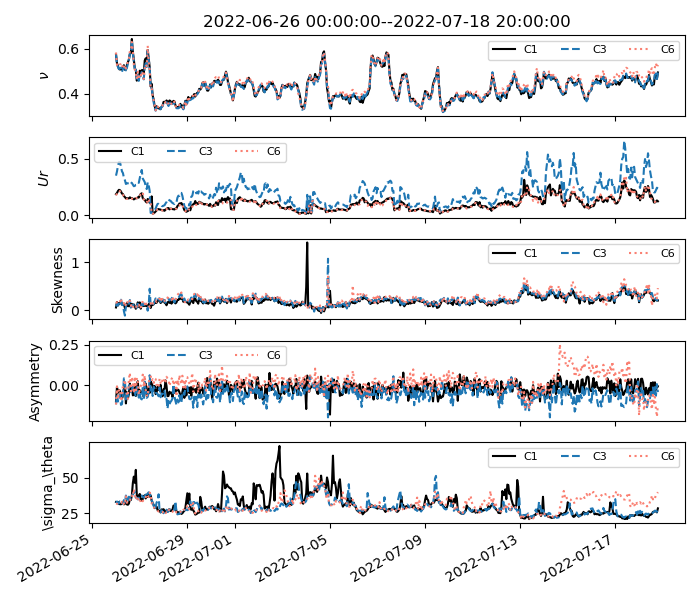

In [73]:
def DoRotation(u, v, rot=0):
    """
    Rotate velocity components u and v by angle rot [rad].
    """
    # Clockwise, 2D rotation matrix
    RotMatrix = np.array([[np.cos(rot),  np.sin(rot)],
                          [-np.sin(rot), np.cos(rot)]])
    return RotMatrix @ np.vstack([u, v])

mids = ['C1', 'C3', 'C6',]# 'L1',] # Mooring IDs
sers = ['103088', '103094', '103110',]# '103063',] # Serial numbers
spec_key = 'ASTd' # Surface elevation product to use for spectra

# Make date range array for iterating over
t0 = pd.Timestamp('2022-06-26 00:00:00') # start date
t1 = pd.Timestamp('2022-07-18 20:00:00') # end date
# t0 = pd.Timestamp('2022-07-13 00:00:00') # start date
# t1 = pd.Timestamp('2022-07-14 11:00:00') # end date
date_range = pd.date_range(t0.date(), t1.date(), freq='1D')

# Min/max frequency range to plot
fmin = 0.05
fmax = 0.5

# Plot parameters
fontsz = 9
# Colormap vmin, vmax
vmin = 0.5
vmax = 1.5
# cs = ['indigo', 'royalblue', 'turquoise']
cs = ['k', 'C0', 'salmon', 'gray', 'red']
lss = ['-', '--', ':', '-', '-']

# Get C3 spectrum directories
specdir = os.path.join(data_root, '103094', 'Spectra') # Spectra netcdf directory
# List spectrum netcdf files for specified serial number
fns_nc_spec = sorted(glob.glob(os.path.join(specdir, '*{}_*.nc'.format(spec_key))))
dssl = [] # Empty list for concatenating spectrum datasets
# Iterate over and read files, and append to list for concatenating
for fns in tqdm(fns_nc_spec):
    # Read spectrum netcdf
    dss = xr.decode_cf(xr.open_dataset(fns, decode_coords='all'))
    dssl.append(dss) # Append daily spectra to list
# Concatenate C3 20-min spectra
ds20_c3 = xr.concat(dssl, dim='time')
# Use max. depth from mean surface of C3 as depth from surface for all 2-h spectra
maxd = (ds20_c3.water_depth - ds20_c3.vel_binh).max().item()

# Save 1-h spectra to lists in dict for concatenating
specs = {'C1':[], 'C3':[], 'C6':[], 'L1':[], }
specsf = {'C1':[], 'C3':[], 'C6':[], 'L1':[], }
# Iterate over dates in requested period and compute spectra
for date in date_range:
    # Iterate over mooring IDs and serial numbers
    for i, (mid, ser) in enumerate(zip(mids, sers)):
        # Signature velocity netcdf directory
        veldir = os.path.join(data_root, '{}'.format(ser)) 
        # List netcdf files in veldir
        fns_v = sorted(glob.glob(os.path.join(veldir, 'Asilomar_*.nc')))
        # Read Signature velocity dataset for current date
        datestr = '{}{:02d}{:02d}'.format(date.year, date.month, date.day)
        fn_sig = [f for f in fns_v if datestr in f]
        sk = np.logical_and(mid in ['C3', 'C6', 'L1'], str(date.date())=='2022-06-30')
        if not sk:
            ds = xr.decode_cf(xr.open_dataset(fn_sig[0], decode_coords='all'))
        else:
            fn_sig = [f for f in fns_v if '20220701' in f]
            ds = xr.decode_cf(xr.open_dataset(fn_sig[0], decode_coords='all'))
        # Iterate over 2-h periods for spectra
        time_range = pd.date_range(date, date + pd.Timedelta(days=1), freq='1H')
        for si, (t0s, t1s) in enumerate(zip(time_range[:-1], time_range[1:])):
            # Don't go past end timestamp or start before start timestamp
            if t1s > t1 or t0s < t0:
                continue
            # Take 20-min slice from dataset
            seg = ds.sel(time=slice(t0s, t1s)).copy() # Segment slice
            # Get optimal range value using C3 maxd
            vel_range = depth - maxd
            # Get u,v velocities for directional wave spectrum
            depth = seg.z_lin.mean().item() # Mean depth
            # Get optimal range value using C3 maxd
            vel_range = depth - maxd
            z = seg.ASTd_eta.values
            # Rotate E/N velocities to local coordinate system
            # u = seg.vEhpr.sel(range=vel_range, method='nearest').values
            # v = seg.vNhpr.sel(range=vel_range, method='nearest').values
            ui = seg.vEhpr.values
            vi = seg.vNhpr.values
            # Angles
            angle_met = 300
            angle_math = 270 - angle_met
            if angle_math < 0:
                angle_math += 360
            angle_math = np.deg2rad(angle_math)
            ul = np.ones_like(ui) * np.nan
            vl = np.ones_like(vi) * np.nan
            for i,r in enumerate(seg.range.values):
                ur = seg.vEhpr.sel(range=r).values.copy()
                vr = seg.vNhpr.sel(range=r).values.copy()
                ul[:,i], vl[:,i] = DoRotation(ur, vr, angle_math)
            seg['vEr'] = (['time', 'range'], ul)
            seg['vNr'] = (['time', 'range'], vl)
            # Select velocities from optimal depth bin for spectral estimation
            u = seg.vEr.sel(range=vel_range, method='nearest').values
            v = seg.vNr.sel(range=vel_range, method='nearest').values
            z = seg.ASTd_eta.values
            # Band-pass filter surface elevation at 0.05-1.0 Hz
            sos = signal.butter(2, [0.05, 1.0], 'bp', fs=4, output='sos')
            zf = signal.sosfilt(sos, z)
            # Compute skewness, asymmetry and kurtosis for both filtered/unfiltered z
            sk = stats.skew(z)
            skf = stats.skew(zf)
            asym = stats.skew(np.imag(signal.hilbert(z)))
            asymf = stats.skew(np.imag(signal.hilbert(zf)))
            kt = stats.kurtosis(z)
            ktf = stats.kurtosis(zf)
            # Compute spectra of filtered/unfiltered z
            spec = rpws.spec_uvz(z, u=u, v=v, fs=4, timestamp=t0s.floor('20T'), fmin=fmin, fmax=fmax)
            # Save depth, Ur, skew, asym & kurt to spectrum dataset
            spec['sk'] = ([], sk)
            spec['asym'] = ([], asym)
            spec['kt'] = ([], kt)
            spec['depth'] = ([], depth)
            # Compute Ursell number
            kp = rptf.waveno_full(2*np.pi*(1/spec.Tp_ind.item()), d=depth).item()
            mu = (kp * depth)**2 # Shallowness parameter
            eps = 2 * np.nanstd(zf) / depth
            # Ur = eps / mu
            Ur = (3/4) * (9.81/(8*np.pi**2)) * (spec.Hm0.item()*spec.Tp_ind.item()**2 / depth**2)
            spec['Ur'] = ([], Ur)
            # Append to list
            specs[mid].append(spec)
            # Filtered signal spectrum
            specf = rpws.spec_uvz(zf, fs=4, timestamp=t0s.floor('20T'), fmin=fmin, fmax=fmax)
            # Save skew, asym & kurt to spectrum dataset
            specf['sk'] = ([], skf)
            specf['asym'] = ([], asymf)
            specf['kt'] = ([], ktf)
            specf['depth'] = ([], depth)
            # Compute Ursell number
            kp = rptf.waveno_full(2*np.pi*(1/specf.Tp_ind.item()), d=depth).item()
            muf = (kp * depth)**2 # Shallowness parameter
            epsf = 2 * np.nanstd(zf) / depth
            # Urf = epsf / muf
            Urf = (3/4) * (9.81/(8*np.pi**2)) * (specf.Hm0.item()*specf.Tp_ind.item()**2 / depth**2)
            specf['Ur'] = ([], Urf)
            # Append to list
            specsf[mid].append(specf)

# Concatenate spectra
spc = {} # Unfiltered spectra
spcf = {} # Filtered spectra
for mid in mids:
    spc[mid] = xr.concat(specs[mid], dim='time')
    spcf[mid] = xr.concat(specsf[mid], dim='time')

# Plot
fig, axes = plt.subplots(figsize=(7,6), nrows=5, sharex=True, constrained_layout=True)
for i, mid in enumerate(mids):
    spc[mid].nu_LH57.plot(ax=axes[0], label=mid, color=cs[i], linestyle=lss[i]) # Ursell Number
    spc[mid].Ur.plot(ax=axes[1], label=mid, color=cs[i], linestyle=lss[i]) # Ursell Number
    spc[mid].sk.plot(ax=axes[2], label=mid, color=cs[i], linestyle=lss[i]) # Skewness
    spc[mid].asym.plot(ax=axes[3], label=mid, color=cs[i], linestyle=lss[i]) # Asymmetry
    spc[mid].dspr.plot(ax=axes[4], label=mid, color=cs[i], linestyle=lss[i]) # Kurtosis
    axes[0].set_title('{}--{}'.format(t0, t1))
    axes[0].set_ylabel(r'$\nu$')
    axes[1].set_ylabel(r'$Ur$')
    axes[2].set_ylabel(r'Skewness')
    axes[3].set_ylabel(r'Asymmetry')
    axes[4].set_ylabel(r'\sigma_\theta')

for ax in axes:
    ax.set_xlabel(None)
    ax.legend(ncol=3, fontsize=8)

plt.tight_layout()
plt.show()
# plt.clf()


## Test bicoherence

  0%|          | 0/26 [00:00<?, ?it/s]

append 2022-06-28T00:00:00.000000000
Mooring ID:  C1
vel_range:  5.065029413625869
vel depth:  2.8561119455718798
C1 2022-06-28 08:00:00 Tp: 5.532420522736702
Mooring ID:  C3
vel_range:  2.763761624375991
vel depth:  2.8561119455718793
C3 2022-06-28 08:00:00 Tp: 5.508727785733776
Mooring ID:  C6
vel_range:  5.079087392159687
vel depth:  2.856111945571879
C6 2022-06-28 08:00:00 Tp: 5.48541575309884
vmax:  0.01594972776872099


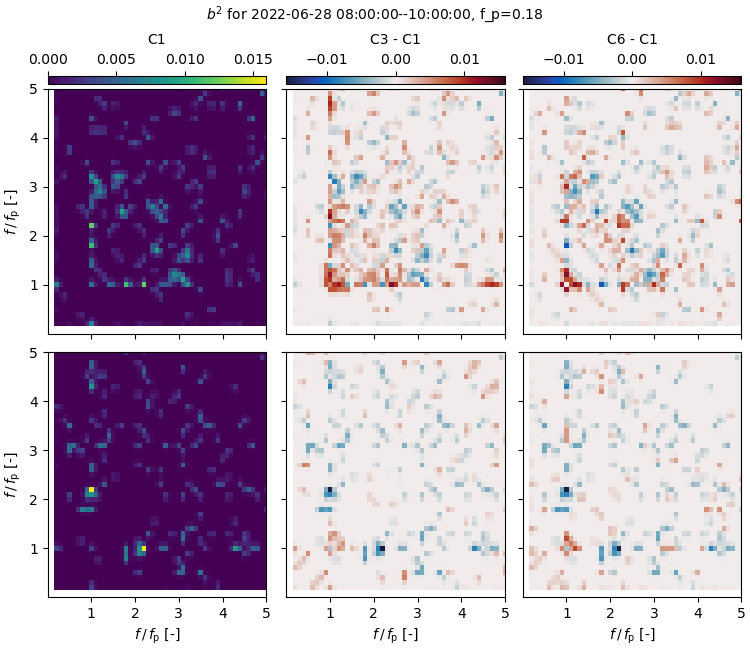

ValueError: Stop

In [7]:
import matplotlib.colors as colors
import matplotlib.dates as mdates
from cmcrameri import cm
from scipy import signal

def DoRotation(u, v, rot=0):
    """
    Rotate velocity components u and v by angle rot [rad].
    """
    # Clockwise, 2D rotation matrix
    RotMatrix = np.array([[np.cos(rot),  np.sin(rot)],
                          [-np.sin(rot), np.cos(rot)]])
    return RotMatrix @ np.vstack([u, v])

def compute_bicoherence(s1, s2, rate, nperseg=512*2, noverlap=512*1):
    """ Compute the bicoherence between two signals of the same lengths s1 and s2
    using the function scipy.signal.spectrogram
    """
    # compute the stft
    f1, t1, spec_s1 = signal.spectrogram(s1, fs=rate, nperseg=nperseg, noverlap=noverlap,
                                         mode='complex',)
    f2, t2, spec_s2 = signal.spectrogram(s2, fs=rate, nperseg=nperseg, noverlap=noverlap,
                                         mode='complex')

    # transpose (f, t) -> (t, f)
    spec_s1 = np.transpose(spec_s1, [1, 0])
    spec_s2 = np.transpose(spec_s2, [1, 0])

    # compute the bicoherence
    arg = np.arange(f1.size / 2).astype(int)
    sumarg = arg[:, None] + arg[None, :]
    num = np.abs(np.mean(
        spec_s1[:, arg, None] * spec_s1[:, None, arg] * np.conjugate(spec_s2[:, sumarg]), 
        axis=0)) ** 2
    denum = (np.mean(np.abs(spec_s1[:, arg, None] * spec_s1[:, None, arg]) ** 2, axis = 0) * 
             np.mean(np.abs(np.conjugate(spec_s2[:, sumarg])) ** 2, axis = 0)
            )
    bicoh = num / denum
    return f1[arg], bicoh

def butter_bandpass(lowcut, highcut, fs, order=5):
    return signal.butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y


mids = ['C1', 'C3', 'C6'] # Mooring IDs
sers = ['103088', '103094', '103110'] # Serial numbers

# Define segment timestamps
t0 = pd.Timestamp('2022-06-28 08:00') # start date
t1 = pd.Timestamp('2022-06-28 22:00') # start date
nh = 2 # number of hours for bicoherence period
tfreq = '{}H'.format(nh) # Time step between timestamps in date range
date_range = pd.date_range(t0, t1, freq=tfreq)

# Min/max frequency range to plot
fmin = 0.001
fmax = 1.0

# Plot parameters
fontsz = 9
# Colormap vmin, vmax
vmin = 0.0
vmax = 1.0
# cs = ['indigo', 'royalblue', 'turquoise']
cs = ['k', 'C0', 'salmon']
lss = ['-', '--', ':']

# Get C3 spectrum directories
spec_key = 'ASTd'
specdir = os.path.join(data_root, '103094', 'Spectra') # Spectra netcdf directory
# List spectrum netcdf files for specified serial number
fns_nc_spec = sorted(glob.glob(os.path.join(specdir, '*{}_*.nc'.format(spec_key))))
dssl = [] # Empty list for concatenating spectrum datasets
# Iterate over and read files, and append to list for concatenating
for fns in tqdm(fns_nc_spec):
    # Read spectrum netcdf
    dss = xr.decode_cf(xr.open_dataset(fns, decode_coords='all'))
    if str(pd.Timestamp(dss.time[0].values).date()) == str(t0.date()):
        print('append {}'.format(dss.time[0].values))
        dssl.append(dss) # Append daily spectra to list
    elif str(pd.Timestamp(dss.time[0].values).date()) == str(t1.date()):
        print('append {}'.format(dss.time[0].values))
        dssl.append(dss) # Append daily spectra to list
# Concatenate C3 20-min spectra
ds20_c3 = xr.concat(dssl, dim='time')
# Use max. depth from mean surface of C3 as depth from surface for all 2-h spectra
maxd = (ds20_c3.water_depth - ds20_c3.vel_binh).max().item()

Bcic = {} # Dict to store concatenated, normalized-frequency bicoherence DataArrays
# Iterate over 2-h periods and compute and plot bicoherence
for t0s in date_range:
    t1s = t0s + pd.Timedelta(hours=nh)

    da_int = [] # Empty list to store interpolated bicoherence arrays for concatenating

    bcid = {}
    bciud = {}
    # Iterate over mooring IDs and serial numbers
    for i, (mid, ser) in enumerate(zip(mids, sers)):
        print('Mooring ID: ', mid)
        # Signature velocity netcdf directory
        veldir = os.path.join(data_root, '{}'.format(ser)) 
        # List netcdf files in veldir
        fns_v = sorted(glob.glob(os.path.join(veldir, 'Asilomar_*.nc')))
        # Read Signature velocity dataset for current date
        datestr = '{}{:02d}{:02d}'.format(t0s.year, t0s.month, t0s.day)
        fn_sig = [f for f in fns_v if datestr in f]
        sk = np.logical_and(np.logical_or(mid=='C3', mid=='C6'), str(t0s.date())=='2022-06-30')
        if not sk:
            ds = xr.decode_cf(xr.open_dataset(fn_sig[0], decode_coords='all'))
        else:
            fn_sig = [f for f in fns_v if '20220701' in f]
            ds = xr.decode_cf(xr.open_dataset(fn_sig[0], decode_coords='all'))
        # Take requested segment from dataset
        seg = ds.sel(time=slice(t0s, t1s)).copy() # Segment slice
        # Directional wave spectra
        depth = seg.z_lin.mean().item() # Mean depth
        vel_range = depth - maxd
        # Rotate E/N velocities to local coordinate system
        ui = seg.vEhpr.values
        vi = seg.vNhpr.values
        # Angles
        angle_met = 300
        angle_math = 270 - angle_met
        if angle_math < 0:
            angle_math += 360
        angle_math = np.deg2rad(angle_math)
        ul = np.ones_like(ui) * np.nan
        vl = np.ones_like(vi) * np.nan
        for ii,r in enumerate(seg.range.values):
            ur = seg.vEhpr.sel(range=r).values.copy()
            vr = seg.vNhpr.sel(range=r).values.copy()
            ul[:,ii], vl[:,ii] = rpct.rotate_vel(ur, vr, angle_math)
        seg['vEr'] = (['time', 'range'], ul)
        seg['vNr'] = (['time', 'range'], vl)
        # Select velocities from optimal depth bin for spectral estimation
        print('vel_range: ', vel_range)
        print('vel depth: ', (depth - vel_range))
        u = seg.vEr.sel(range=vel_range, method='nearest').values
        v = seg.vNr.sel(range=vel_range, method='nearest').values
        # Use AST and cross-shore vel. u for bispectrum
        z = seg.ASTd_eta.values
        # Estimate regular spectrum
        spec = rpws.spec_uvz(z=z, u=u, v=v, fs=4, wsec=128, fmerge=3)
        print('{} {} Tp: {}'.format(mid, t0s, spec.Tp_Y95.item()))
        # Estimate bispectrum and plot bicoherence
        dsb = rpws.bispectrum(z=z, fs=4, wsec=128, fmerge=3)
        dsbu = rpws.bispectrum(z=u, fs=4, wsec=128, fmerge=3)
        # Interpolate bicoherence**2 onto frequency/fp normalized grid
        f1n = (dsb.freq1 / (1 / spec.Tp_Y95.item()))
        f2n = (dsb.freq2 / (1 / spec.Tp_Y95.item()))
        Bc = dsb.Bc
        Bcu = dsbu.Bc
        # Mask out non-significant bicoh
        Bc = Bc.where(Bc >= dsb.b95.item()).fillna(0)
        Bcu = Bcu.where(Bcu >= dsbu.b95.item()).fillna(0)
        # Make target normalized frequencies
        nt = 51 # Number of normalized target frequencies
        f1nt = np.linspace(0, 5, nt)
        f2nt = np.linspace(0, 5, nt)
        # Old array to interpolate
        old = xr.DataArray(Bc.values, [('f1n', f1n.values), ('f2n', f2n.values)])
        oldu = xr.DataArray(Bcu.values, [('f1n', f1n.values), ('f2n', f2n.values)])
        # Make new DataArray using target frequencies for interpolation
        target = xr.DataArray(np.zeros((nt, nt)), [('f1n', f1nt), ('f2n', f2nt)])
        targetu = xr.DataArray(np.zeros((nt, nt)), [('f1n', f1nt), ('f2n', f2nt)])
        # Interpolate bicoherence to target normalized frequencies
        Bci = old.interp_like(target)
        Bciu = oldu.interp_like(targetu)
        # Add time coord to interpolated array
        Bci = Bci.assign_coords(time=t0)
        Bciu = Bciu.assign_coords(time=t0)
        # Save to dicts for plotting
        bcid[mid] = Bci
        bciud[mid] = Bciu
        # Append to list for averaging
        # da_int.append(Bci)

    # Initialize figure
    fig, axes = plt.subplots(figsize=(7.5,6.5), ncols=3, nrows=2, sharex=True, sharey=True, 
        constrained_layout=True,)
    for i,mid in enumerate(mids):
        # Plot squared bicoherence Bc**2
        if i == 0:
            # Absolute bicoh**2 values for C1
            vmax = np.max(((bcid['C1']**2).max(), (bciud['C1']**2).max()))
            print('vmax: ', vmax)
            im = (bcid['C1']**2).plot.pcolormesh(x='f1n', y='f2n', ax=axes[0,i], 
                vmin=0, vmax=vmax, add_colorbar=False)
            # C-S velocity bicoh
            imu = (bciud['C1']**2).plot.pcolormesh(x='f1n', y='f2n', ax=axes[1,i], 
                vmin=0, vmax=vmax, add_colorbar=False)
            cax = axes[0,0].inset_axes([0, 1.02, 1.0, 0.03])
            cb = fig.colorbar(im, ax=axes[0,0], cax=cax, orientation='horizontal')
            cb.ax.xaxis.set_label_position('top')
            cb.ax.xaxis.set_ticks_position('top')
            axes[0,i].set_title(mid, fontsize=10)
            axes[1,i].set_title(None)
            axes[0,i].set_xlabel(None)
            axes[1,i].set_xlabel(None)
        # Get vmin, vmax for difference plots
        ratio31 = (bcid['C3']**2 - bcid['C1']**2)
        ratiou31 = (bciud['C3']**2 - bciud['C1']**2)
        ratio61 = (bcid['C6']**2 - bcid['C1']**2)
        ratiou61 = (bciud['C6']**2 - bciud['C1']**2)
        minr = np.min((ratio31.min(), ratiou31.min(), ratio61.min(), ratiou61.min()))
        maxr = np.max((ratio31.max(), ratiou31.max(), ratio61.max(), ratiou61.max()))
        vmin = -np.max((np.abs(minr), np.abs(maxr)))
        vmax = np.max((np.abs(minr), np.abs(maxr)))
        if i == 1:
            # No colorbar for middle panel, but plot C3 / C1 ratio
            im = ratio31.plot.pcolormesh(x='f1n', y='f2n', ax=axes[0,i], add_colorbar=False, 
                cmap=cmocean.cm.balance, vmin=vmin, vmax=vmax)
            imu = ratiou31.plot.pcolormesh(x='f1n', y='f2n', ax=axes[1,i], add_colorbar=False, 
                cmap=cmocean.cm.balance, vmin=vmin, vmax=vmax)
            cax = axes[0,1].inset_axes([0, 1.02, 1.0, 0.03])
            cb = fig.colorbar(im, ax=axes[0,1], cax=cax, orientation='horizontal')
            cb.ax.xaxis.set_label_position('top')
            cb.ax.xaxis.set_ticks_position('top')
            axes[0,i].set_title('C3 - C1', fontsize=10)
            axes[1,i].set_title(None)
            axes[0,i].set_xlabel(None)
            axes[1,i].set_xlabel(None)
        elif i == 2:
            im = ratio61.plot.pcolormesh(x='f1n', y='f2n', ax=axes[0,i], add_colorbar=False,
                cmap=cmocean.cm.balance, vmin=vmin, vmax=vmax)
            im = ratiou61.plot.pcolormesh(x='f1n', y='f2n', ax=axes[1,i], add_colorbar=False,
                cmap=cmocean.cm.balance, vmin=vmin, vmax=vmax)
            cax = axes[0,2].inset_axes([0, 1.02, 1.0, 0.03])
            cb = fig.colorbar(im, ax=axes[0,2], cax=cax, orientation='horizontal')
            cb.ax.xaxis.set_label_position('top')
            cb.ax.xaxis.set_ticks_position('top')
            axes[0,i].set_title('C6 - C1', fontsize=10)
            axes[1,i].set_title(None)
            axes[0,i].set_xlabel(None)
            axes[1,i].set_xlabel(None)
        axes[0,i].set_xticks([0, 1, 2, 3, 4, 5])
        axes[0,i].set_yticks([0, 1, 2, 3, 4, 5])
        axes[0,i].set_xlim([0.001,5])
        axes[0,i].set_ylim([0.001,5])
        axes[1,i].set_xlabel(r'$f \, / \, f_\mathrm{p}$ [-]')
        axes[0,i].set_ylabel(None)
        axes[1,i].set_ylabel(None)

        axes[0,0].set_ylabel(r'$f \, / \, f_\mathrm{p}$ [-]')
        axes[1,0].set_ylabel(r'$f \, / \, f_\mathrm{p}$ [-]')

    plt.suptitle(r'$b^2$ for {}--{}, f_p={:.2f}'.format(str(t0s), str(t1s.time()), (1/spec.Tp_Y95.item())),
        fontsize=10)
    plt.show()
    raise ValueError('Stop')

    # Concatenate normalized bicoh arrays
    # Bcic[mid] = xr.concat(da_int, dim='time')

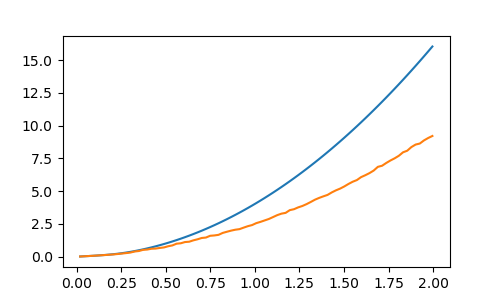

In [21]:
# Bcic.sel(f1n=slice(0.75, 1.25), f2n=slice(0.75, 1.25)).mean()
# Bcic.sel(f1n=slice(1.25, 1.75), f2n=slice(1.25, 1.75)).mean()
P = spec.Ezz.values
B = dsb.B.values
f = spec.freq.values
k = rpws.waveno_full(np.pi*2*f, d=depth) 
krms = rpws.k_rms(h0=depth, f=f, P=P, B=B, two_sided=False)
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(f, k)
ax.plot(f, krms)

In [50]:
from roxsi_pyfuns import transfer_functions as rptf
fig, ax = plt.subplots(figsize=(5,5))
spec = rpws.spec_uvz(z=seg.pressure.values, fs=4)
ax.loglog(spec.freq.values, spec.Ezz.values)
spec = rpws.spec_uvz(z=seg.ASTd_eta.values, fs=4)
ax.loglog(spec.freq.values, spec.Ezz.values)
ax.axvline(x=0.7, linestyle='--', color='k')
trf = rptf.TRF(zp=0.3, fs=4)
elk, enk = trf.p2eta_krms(seg.eta_hyd, h0=depth, fc=0.5, fmax=1)
spec = rpws.spec_uvz(z=elk, fs=4)
ax.loglog(spec.freq.values, spec.Ezz.values)
spec = rpws.spec_uvz(z=enk, fs=4)
ax.loglog(spec.freq.values, spec.Ezz.values)
plt.show()

Calculating bispectrum ...


## Check individual timeseries
Plot time series of surface elevation alongside heading, pitch and roll for C1 vs. C3 vs. C6 for requested time period.

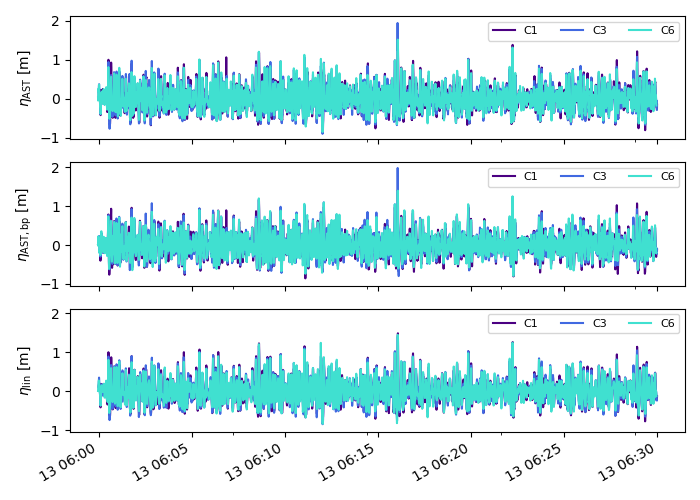

In [41]:
from scipy import signal

def butter_bandpass(lowcut, highcut, fs, order=5):
    return signal.butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

# Make date range array for iterating over
t0 = pd.Timestamp('2022-07-13 06:00:00') # Start date
t1 = t0 + pd.Timedelta(minutes=30) # End date
# t1 = pd.Timestamp('2022-06-28 10:30:00') # end date
# Plot key
key_a = 'ASTd_eta'
key_l = 'eta_lin'

mids = ['C1', 'C3', 'C6']

# Plot parameters
cs = ['indigo', 'royalblue', 'turquoise']
lines = ['-', '--', ':']

# Initialize daily spectra figure
fig, axes = plt.subplots(figsize=(7,5), nrows=3, sharex=True, constrained_layout=True,
                         gridspec_kw={'height_ratios': [3,3,3]}, sharey=True)
# Iterate over mooring IDs and serial numbers
segs_ast = [] # List to store aligned AST segments
segs_ast_bp = [] # List to store aligned and bandpassed AST segments
segs_lin = [] # List to store aligned eta_lin segments
for i, (mid, ser) in enumerate(zip(mids, sers)):
    # Signature velocity netcdf directory
    veldir = os.path.join(data_root, '{}'.format(ser)) 
    # List netcdf files in veldir
    fns_v = sorted(glob.glob(os.path.join(veldir, 'Asilomar_*.nc')))
    # Read Signature velocity dataset for current date
    datestr = '{}{:02d}{:02d}'.format(t0.year, t0.month, t0.day)
    fn_sig = [f for f in fns_v if datestr in f]
    sk = np.logical_and(np.logical_or(mid=='C3', mid=='C6'), str(t0.date())=='2022-06-30')
    if not sk:
        ds = xr.decode_cf(xr.open_dataset(fn_sig[0], decode_coords='all'))
    else:
        fn_sig = [f for f in fns_v if '20220701' in f]
        ds = xr.decode_cf(xr.open_dataset(fn_sig[0], decode_coords='all'))
    # Take requested slice from dataset and plot time series
    seg = ds.sel(time=slice(t0, t1)).copy() # Segment slice
    # H, P, R on 1st row
#     if i == 0:
#         seg.heading_ang.plot(ax=axes[0], color=colors[i], label='head', linestyle='-')
#         seg.pitch_ang.plot(ax=axes[0], color=colors[i], label='pitch', linestyle='--')
#         seg.roll_ang.plot(ax=axes[0], color=colors[i], label='roll', linestyle=':')
#     else:
#         seg.heading_ang.plot(ax=axes[0], color=colors[i], linestyle='-')
#         seg.pitch_ang.plot(ax=axes[0], color=colors[i], linestyle='--')
#         seg.roll_ang.plot(ax=axes[0], color=colors[i], linestyle=':')
    segs_ast.append(seg[key_a])
    segs_lin.append(seg[key_l])
    # Band-pass AST signal
    sos = signal.butter(2, [0.05, 1.0], 'bp', fs=4, output='sos')
    bps = signal.sosfilt(sos, seg[key_a].values)
    # bps = butter_bandpass_filter(seg[key_a].values, lowcut=0.05, highcut=1.0, fs=4)
    bps = pd.Series(bps, index=seg.time.values)
    segs_ast_bp.append(bps)

# Use first available AST signal as reference signal
ref_seg_ast = segs_ast[0].to_series()
segs_aligned_ast = [] # List to store aligned signals
# Shift the AST remaining signals based on correlation against reference signal
for ss in segs_ast[1:]:
    # Align AST signals
    df_shifted_ast = ss.copy().to_series()
    # Calculate number of indices to shift to get max correlation with reference signal
    shift = np.argmax(signal.correlate(ref_seg_ast, df_shifted_ast)) - len(df_shifted_ast)
    # Shift current record
    rec_shift = df_shifted_ast.shift(shift, freq='250ms')
    segs_aligned_ast.append(rec_shift)

# Use first available band-passed AST signal as reference signal
ref_seg_ast_bp = segs_ast_bp[0]
segs_aligned_ast_bp = [] # List to store aligned band-passed signals
# Shift the remaining band-passed AST signals based on correlation against reference signal
for ss in segs_ast_bp[1:]:
    # Align band-passed AST signals
    df_shifted_ast_bp = ss.copy()
    # Calculate number of indices to shift to get max correlation with reference signal
    shift = np.argmax(signal.correlate(ref_seg_ast_bp, df_shifted_ast_bp)) - len(df_shifted_ast_bp)
    # Shift current record
    rec_shift = df_shifted_ast_bp.shift(shift, freq='250ms')
    segs_aligned_ast_bp.append(rec_shift)

# Also align linear eta signals
ref_seg_lin = segs_lin[0].to_series()
segs_aligned_lin = [] # List to store aligned signals
# Shift the AST remaining signals based on correlation against reference signal
for ss in segs_lin[1:]:
    # Align AST signals
    df_shifted_lin = ss.copy().to_series()
    # Calculate number of indices to shift to get max correlation with reference signal
    shift = np.argmax(signal.correlate(ref_seg_lin, df_shifted_lin)) - len(df_shifted_lin)
    # Shift current record
    rec_shift = df_shifted_lin.shift(shift, freq='250ms')
    segs_aligned_lin.append(rec_shift)

# Plot aligned AST surface elevations on second row
ref_seg_ast.plot(ax=axes[0], color=cs[0], label=mids[0], legend=False)
for i,s in enumerate(segs_aligned_ast): 
    s.plot(ax=axes[0], color=cs[i+1], label=mids[i+1], legend=False)

# Plot aligned AST surface elevations on second row
ref_seg_ast_bp.plot(ax=axes[1], color=cs[0], label=mids[0], legend=False)
for i,s in enumerate(segs_aligned_ast_bp): 
    s.plot(ax=axes[1], color=cs[i+1], label=mids[i+1], legend=False)

# Plot aligned linear surface elevations on third row
ref_seg_lin.plot(ax=axes[2], color=cs[0], label=mids[0], legend=False)
for i,s in enumerate(segs_aligned_lin): 
    s.plot(ax=axes[2], color=cs[i+1], label=mids[i+1], legend=False)

# axes[0].set_ylabel('Angle [deg]')
axes[0].set_ylabel(r'$\eta_{\mathrm{AST}}$ [m]')
axes[1].set_ylabel(r'$\eta_{\mathrm{AST, bp}}$ [m]')
axes[2].set_ylabel(r'$\eta_{\mathrm{lin}}$ [m]')
for ax in axes:
    ax.legend(ncols=3, fontsize=8)
    ax.set_xlabel(None)
plt.tight_layout()
plt.show()
# plt.clf()


## Check echosounder data

0it [00:00, ?it/s]

Found mat file:  S103110A003_AS22_SS_0019_4.mat


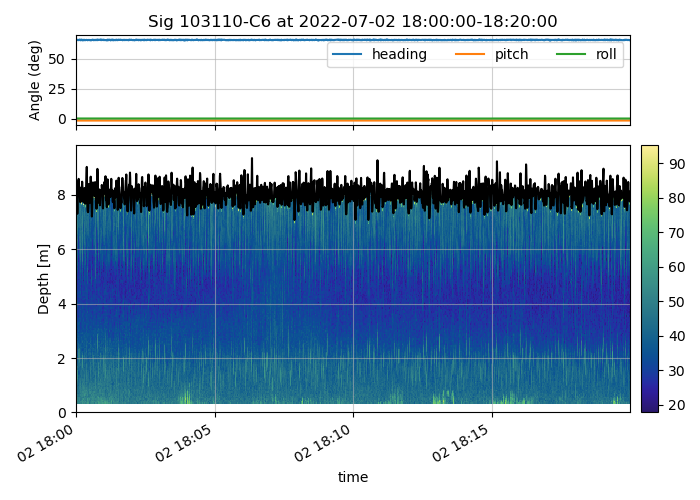

In [6]:
# Read short period of echosounder data (very large)
ser = '103110'
if ser == '103110': mid='C6'
elif ser == '103094': mid='C3'
elif ser == '103088': mid='C1'
elif ser == '103064': mid='L1'
elif ser == '103206': mid='L5'
# Initialize ADCP data reader class
rawdir = os.path.join(rootdir, 'Signatures', 'raw', ser) # Raw .mat files directory
adcp = rpsp.ADCP(datadir=rawdir, ser=ser)
# Define start and end times of echogram chunk
t0 = pd.Timestamp('2022-07-02 18:00:00')
t1 = pd.Timestamp('2022-07-02 18:20:00')
# Remove base path from filenames
fns_split = [os.path.split(f)[1] for f in adcp.fns] 
# Read/Save dataframe with start/end times for each .mat filename
dfm = pd.DataFrame(data={'t0':np.ones(len(adcp.fns))*np.nan,
                         't1':np.ones(len(adcp.fns))*np.nan},
                   index=fns_split)
fn_dfm = os.path.join(rawdir, 'mat_times_{}.csv'.format(ser))
if os.path.isfile(fn_dfm):
    dfm = pd.read_csv(fn_dfm, parse_dates=['t0', 't1'], index_col=0)
# Iterate over mat files and find file that contains requested time period
for i,fnm in tqdm(enumerate(fns_split)):
    if os.path.isfile(fn_dfm):
        # Get start/end times for current .mat file from csv
        mt0 = dfm.loc[os.path.split(fnm)[1]].t0
        mt1 = dfm.loc[os.path.split(fnm)[1]].t1
    else:
        # Read only timestamps from .mat file
        _, mt = adcp.read_mat_times(fn_mat=os.path.join(rawdir, fnm))
        # Start and end timestamps of current .mat file
        mt0 = mt[0]
        mt1 = mt[-1]
        # Save to dataframe
        dfm['t0'].loc[fnm] = mt0
        dfm['t1'].loc[fnm] = mt1
    # Check if t0, t1 in hpr timestamps
    if mt0 <= t0 and mt1 >= t1:
        print('Found mat file: ', os.path.split(fnm)[1])
        mat = loadmat(os.path.join(rawdir, fnm))
        dsa = adcp.ampcorr2ds(mat, t0=t0, t1=t1)
        # raise ValueError('Stop')
        # Read echogram data
        dae = adcp.loaddata_vel(fn_mat=os.path.join(rawdir, fnm), 
                                echo=True, et0=t0, et1=t1)
        break
 
# Save dfm to csv
if not os.path.isfile(fn_dfm):
    dfm.to_csv(fn_dfm)

# Read corresponding AST signal for plot
datestr = str(t0.date()).replace('-', '')
veldir = os.path.join(rootdir, 'Signatures', 'Level1', ser)
fns_v = sorted(glob.glob(os.path.join(veldir, 'Asilomar_*.nc')))
fn_sig = [f for f in fns_v if datestr in f]
ds = xr.decode_cf(xr.open_dataset(fn_sig[0], decode_coords='all'))

# Plot resampled and coarsened echogram data (time: 1-sec avg, z=10 bin-avg)
fig, axes = plt.subplots(figsize=(7,5), nrows=2, gridspec_kw={'height_ratios': [1, 3]},
                         sharex=True, constrained_layout=True)
dtr = '500ms' # Resampled time resolution (milliseconds)
dzr = 10 # Resampled vertical resolution (m)
# Crop ds (only keep AST, z_lin & HPR signals)
cols = ['ASTd', 'z_lin', 'heading_ang', 'pitch_ang', 'roll_ang']
ds = ds[cols].sel(time=slice(t0, t1)).resample(time=dtr).mean()
# Plot H,P,R timeseries on top
ds.heading_ang.plot(ax=axes[0], label='heading')
ds.pitch_ang.plot(ax=axes[0], label='pitch')
ds.roll_ang.plot(ax=axes[0], label='roll')
axes[0].legend(ncol=3)
axes[0].set_ylabel('Angle (deg)')
axes[0].set_xlabel(None)
axes[0].set_title('Sig {}-{} at {}-{}'.format(ser, mid, t0, str(t1.time())))
# Coarsen (in z) and resample (in time) echogram returns
echo = dae.resample(time=dtr).mean().coarsen(z=dzr).mean()
# echo = dae.coarsen(z=dzr).mean()
# Mask echogram data above AST signal and plot
im = echo.where(echo.z<=ds.ASTd).plot(x='time', y='z', ax=axes[1], add_colorbar=False,
        cmap=cmocean.cm.haline)
# Also plot AST and z_lin signals
ds.ASTd.plot(ax=axes[1], color='k')
# ds.z_lin.plot(ax=axes[1], color='C1')
axes[1].set_ylim([0, ds.ASTd.max()+0.5])
axes[1].set_ylabel('Depth [m]')

for ax in axes:
    ax.grid(alpha=0.6)

cax = ax.inset_axes([1.02, 0.0, 0.03, 1.0])
fig.colorbar(im, ax=axes[1], cax=cax)

plt.tight_layout()
plt.show()
# plt.clf()

0it [00:00, ?it/s]

Found mat file:  S103094A001_AS22_SS_0009_3.mat


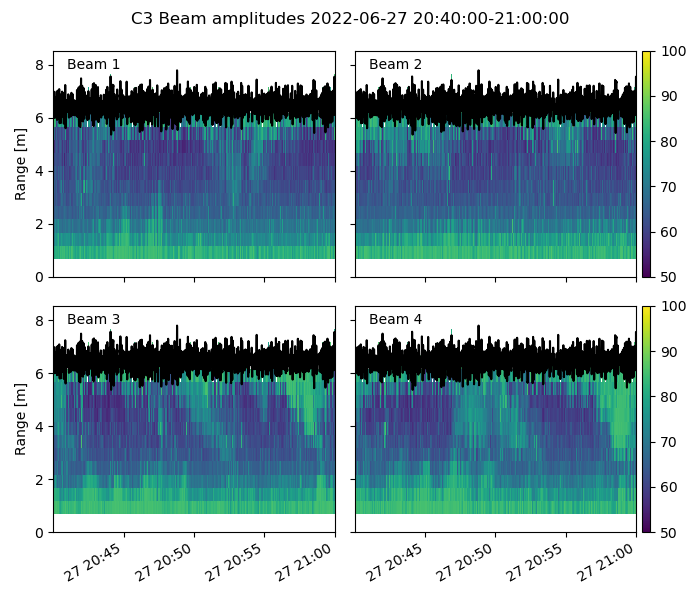

In [6]:
# Read short period of echosounder data (very large)
ser = '103094'
if ser == '103110': mid='C6'
elif ser == '103094': mid='C3'
elif ser == '103088': mid='C1'
elif ser == '103064': mid='L1'
elif ser == '103206': mid='L5'
# Initialize ADCP data reader class
rawdir = os.path.join(rootdir, 'Signatures', 'raw', ser) # Raw .mat files directory
adcp = rpsp.ADCP(datadir=rawdir, ser=ser)
# Define start and end times of echogram chunk
t0 = pd.Timestamp('2022-06-27 20:40:00')
t1 = pd.Timestamp('2022-06-27 21:00:00')
# Remove base path from filenames
fns_split = [os.path.split(f)[1] for f in adcp.fns] 
# Read/Save dataframe with start/end times for each .mat filename
dfm = pd.DataFrame(data={'t0':np.ones(len(adcp.fns))*np.nan,
                         't1':np.ones(len(adcp.fns))*np.nan},
                   index=fns_split)
fn_dfm = os.path.join(rawdir, 'mat_times_{}.csv'.format(ser))
if os.path.isfile(fn_dfm):
    dfm = pd.read_csv(fn_dfm, parse_dates=['t0', 't1'], index_col=0)
# Iterate over mat files and find file that contains requested time period
for i,fnm in tqdm(enumerate(fns_split)):
    if os.path.isfile(fn_dfm):
        # Get start/end times for current .mat file from csv
        mt0 = dfm.loc[os.path.split(fnm)[1]].t0
        mt1 = dfm.loc[os.path.split(fnm)[1]].t1
    else:
        # Read only timestamps from .mat file
        _, mt = adcp.read_mat_times(fn_mat=os.path.join(rawdir, fnm))
        # Start and end timestamps of current .mat file
        mt0 = mt[0]
        mt1 = mt[-1]
        # Save to dataframe
        dfm['t0'].loc[fnm] = mt0
        dfm['t1'].loc[fnm] = mt1
    # Check if t0, t1 in hpr timestamps
    if mt0.floor('20T') <= t0 and mt1.ceil('20T') >= t1:
        print('Found mat file: ', os.path.split(fnm)[1])
        mat = loadmat(os.path.join(rawdir, fnm))
        dsa = adcp.ampcorr2ds(mat, t0=t0, t1=t1)
        # raise ValueError('Stop')
        # Read echogram data
        dae = adcp.loaddata_vel(fn_mat=os.path.join(rawdir, fnm), 
                                echo=True, et0=t0, et1=t1)

# Read corresponding AST signal for plot
datestr = str(t0.date()).replace('-', '')
veldir = os.path.join(rootdir, 'Signatures', 'Level1', ser)
fns_v = sorted(glob.glob(os.path.join(veldir, 'Asilomar_*.nc')))
fn_sig = [f for f in fns_v if datestr in f]
ds = xr.decode_cf(xr.open_dataset(fn_sig[0], decode_coords='all'))

# Plot
fig, axes = plt.subplots(figsize=(7,6), nrows=2, ncols=2, sharex=True, sharey=True,
    constrained_layout=True)
vmin = 50
vmax = 100
# beam = 1 # Beam number (1-5)
for i in range(4):
    beam = i + 1 # Current beam number to plot
    im = dsa['ab{}'.format(beam)].where(dsa.z<=ds.ASTd).where(
            dsa['ab{}'.format(beam)]>50).plot.pcolormesh(
                x='time', y='z', ax=axes.flat[i], vmin=vmin, vmax=vmax, 
                add_colorbar=False)
    # Annotate beam number
    axes.flat[i].annotate('Beam {}'.format(beam), xy=(0.05, 0.92), 
        xycoords='axes fraction')
    # Colorbars on right
    if i == 1 or i == 3:
        cax = axes.flat[i].inset_axes([1.02, 0.0, 0.03, 1.0])
        fig.colorbar(im, ax=axes.flat[i], cax=cax)

for ax in axes.flat:
    ds.ASTd.plot(ax=ax, color='k')
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_ylim([0, ds.ASTd.max()+0.5])

axes[0,0].set_ylabel('Range [m]')
axes[1,0].set_ylabel('Range [m]')

plt.suptitle('{} Beam amplitudes {}-{}'.format(mid, t0, str(t1.time())))
plt.tight_layout()
plt.show()
# plt.clf()

/home/mikapm/Github/pyROXSI/roxsi_pyfuns/wave_spectra.py:1206: RuntimeWarning: invalid value encountered in divide
  Bc = np.abs(Bm) / np.sqrt(Bd1m*Bd2m)


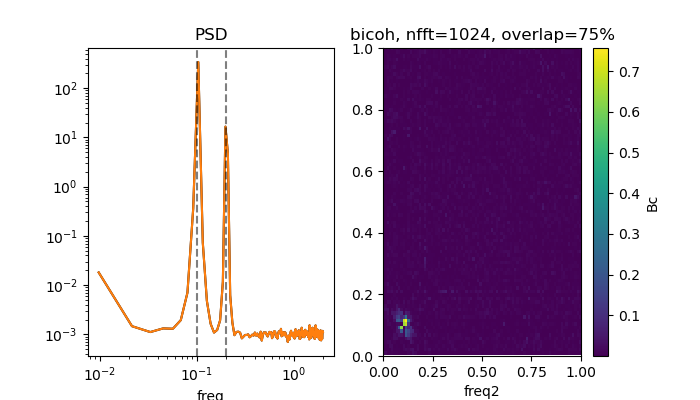

In [8]:
def compute_bicoherence(s1, s2, rate, nperseg=512*4, noverlap=512*3):
    """ Compute the bicoherence between two signals of the same lengths s1 and s2
    using the function scipy.signal.spectrogram
    """
    # compute the stft
    f1, t1, spec_s1 = signal.spectrogram(s1, fs=rate, nperseg=nperseg, noverlap=noverlap,
                                         mode='complex',)
    f2, t2, spec_s2 = signal.spectrogram(s2, fs=rate, nperseg=nperseg, noverlap=noverlap,
                                         mode='complex')

    # transpose (f, t) -> (t, f)
    spec_s1 = np.transpose(spec_s1, [1, 0])
    spec_s2 = np.transpose(spec_s2, [1, 0])

    # compute the bicoherence
    arg = np.arange(f1.size / 2).astype(int)
    sumarg = arg[:, None] + arg[None, :]
    num = np.abs(np.mean(
        spec_s1[:, arg, None] * spec_s1[:, None, arg] * np.conjugate(spec_s2[:, sumarg]), 
        axis=0)) ** 2
    denum = (np.mean(np.abs(spec_s1[:, arg, None] * spec_s1[:, None, arg]) ** 2, axis = 0) * 
             np.mean(np.abs(np.conjugate(spec_s2[:, sumarg])) ** 2, axis = 0)
            )
    bicoh = num / denum
    return f1[arg], bicoh

fs = 4
a = 2 * np.sqrt(2)
fp = 0.1
t = np.arange(3*4800) / fs
noise_power = 1e-3 * fs / 2
eta = a * np.cos( 2*np.pi*fp * t) + a/4 * np.cos( 2 * 2*np.pi*fp * t) 
rng = np.random.default_rng()
noise = rng.normal(scale=np.sqrt(noise_power), size=t.shape)
eta += noise

# fig, ax = plt.subplots(figsize=(7,3))
# ax.plot(t, eta)
# plt.show()

# f, bc = compute_bicoherence(eta, eta, fs,)
overlap = 75 # percent
dsb = rpws.bispec2(z=eta, fs=4, )
sp = rpws.spec_uvz(z=eta, fs=4,)

fig, axes = plt.subplots(figsize=(7,4), ncols=2)
dsb.PSD1.plot(ax=axes[0], color='k')
sp.Ezz.plot(ax=axes[0], color='C1')
axes[0].axvline(x=0.1, color='k', linestyle='--', alpha=0.5)
axes[0].axvline(x=0.2, color='k', linestyle='--', alpha=0.5)
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_title('PSD')
axes[0].set_ylabel(None)
# ax.pcolormesh(f, f, bc)
(dsb.Bc**2).plot.pcolormesh(ax=axes[1])
# (np.real(dsb.B)**2).plot.pcolormesh(ax=ax)
axes[1].set_xlim([0,1])
axes[1].set_ylim([0,1])
axes[1].set_ylabel(None)
axes[1].set_title('bicoh, nfft={}, overlap={}%'.format(nfft, overlap))

plt.show()